Model training and prediction

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Load the data
historical_df = pd.read_csv('final_historical.csv')
future_df = pd.read_csv('future_all_df_wd_85.csv')

# Filter historical data up to 2013 as specified
historical_df['date'] = pd.to_datetime(historical_df['date'])
historical_df = historical_df[historical_df['date'] <= '2013-12-31']

# Format future data dates for consistency
future_df['date'] = pd.to_datetime(future_df['date'], format='%Y-%m')

print(f"Historical data shape: {historical_df.shape}")
print(f"Future data shape: {future_df.shape}")

# 2. Feature Engineering Function
def create_lag_features(df, target_cols, lag_periods=[1, 2, 3], roll_window=7):
    """
    Create lag and rolling features for the target columns.
    
    Parameters:
    df: DataFrame with time-indexed data
    target_cols: List of columns to create lag/rolling features for (D0-D4)
    lag_periods: List of lag periods in months
    roll_window: Window size for rolling calculations in months
    
    Returns:
    DataFrame with added lag and rolling features
    """
    df = df.copy()
    
    # Ensure the dataframe is sorted by date
    df = df.sort_values('date')
    
    # Create lag features for each target column
    for col in target_cols:
        for lag in lag_periods:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Create rolling mean and std features
    for col in target_cols:
        df[f'{col}_roll_mean_{roll_window}'] = df[col].rolling(window=roll_window).mean()
        df[f'{col}_roll_std_{roll_window}'] = df[col].rolling(window=roll_window).std()
    
    return df

# 3. Create features for historical data
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
lag_periods = [1, 2, 3]
roll_window = 7

# Apply feature engineering to historical data
historical_df_features = create_lag_features(historical_df, target_cols, lag_periods, roll_window)

# Drop rows with NaN values (first 7 months due to rolling window)
historical_df_features = historical_df_features.dropna()
print(f"Historical data after feature engineering: {historical_df_features.shape}")

# 4. Prepare training data
# Meteorological and hydrological features
feature_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']

# Add lag and rolling features to the feature columns
for col in target_cols:
    for lag in lag_periods:
        feature_cols.append(f'{col}_lag_{lag}')
    feature_cols.append(f'{col}_roll_mean_{roll_window}')
    feature_cols.append(f'{col}_roll_std_{roll_window}')

# Separate features and targets
X_train = historical_df_features[feature_cols]
Y_train = historical_df_features[target_cols]

# 5. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)

# 6. Train a stacked model for each drought severity level
models = {}
for col in target_cols:
    # Base estimators
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    
    # Stacked model
    estimators = [('rf', rf), ('xgb', xgb)]
    stacked_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
    
    # Train the model
    stacked_model.fit(X_train_scaled, Y_train[col])
    
    # Save the model
    models[col] = stacked_model
    
    # Print model performance
    y_pred = stacked_model.predict(X_train_scaled)
    r2 = r2_score(Y_train[col], y_pred)
    print(f"R² score for {col}: {r2:.4f}")

# 7. Autoregressive prediction function
def autoregressive_predict(models, scaler, future_df, historical_df, target_cols, lag_periods, roll_window, feature_cols):
    """
    Make autoregressive predictions on future data.
    
    Parameters:
    models: Dictionary of trained models for each target
    scaler: Fitted StandardScaler
    future_df: DataFrame with future meteorological/hydrological data
    historical_df: DataFrame with historical data including D0-D4
    target_cols: List of target columns (D0-D4)
    lag_periods: List of lag periods
    roll_window: Rolling window size
    feature_cols: List of feature columns
    
    Returns:
    DataFrame with predictions
    """
    # Prepare a dataframe for predictions that includes historical + future data
    # This allows us to create proper lag/rolling features at the boundary
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('date')
    
    # Initialize target columns in future data with NaN
    for col in target_cols:
        if col not in combined_df.columns:
            combined_df[col] = np.nan
    
    # Identify the boundary between historical and future data
    future_start_idx = combined_df[combined_df['date'] >= future_df['date'].min()].index[0]
    
    # Iteratively predict one month at a time
    for i in range(future_start_idx, len(combined_df)):
        # Create lag and rolling features up to the current point
        temp_df = combined_df.iloc[:i+1].copy()
        temp_df = create_lag_features(temp_df, target_cols, lag_periods, roll_window)
        
        # If we have all required features (no NaN), make a prediction
        current_row = temp_df.iloc[-1:].copy()
        
        # Check if we have all required features
        if not current_row[feature_cols].isna().any().any():
            # Scale features
            current_features = current_row[feature_cols]
            current_features_scaled = scaler.transform(current_features)
            
            # Make predictions for each target
            for col in target_cols:
                prediction = models[col].predict(current_features_scaled)[0]
                combined_df.loc[i, col] = prediction
    
    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= future_df['date'].min()].copy()
    
    return future_predictions

# 8. Make autoregressive predictions
future_predictions = autoregressive_predict(
    models, scaler, future_df, historical_df, 
    target_cols, lag_periods, roll_window, feature_cols
)

# 9. Visualize predictions
plt.figure(figsize=(15, 10))

for i, col in enumerate(target_cols):
    plt.subplot(3, 2, i+1)
    
    # Plot historical data
    plt.plot(historical_df['date'], historical_df[col], label='Historical')
    
    # Plot predictions
    plt.plot(future_predictions['date'], future_predictions[col], label='Predicted')
    
    plt.title(f'Drought Severity: {col}')
    plt.xlabel('Date')
    plt.ylabel('Percent Area')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('drought_predictions.png')
plt.close()

# 10. Save predictions to CSV
future_predictions.to_csv('future_drought_predictions.csv', index=False)

print("Autoregressive prediction completed and saved to 'future_drought_predictions.csv'")

# 11. Additional analysis - check how well the model predicts historical data
# For this, we can simulate an autoregressive approach on the last year of historical data
test_cutoff = pd.to_datetime('2012-12-31')
train_df = historical_df[historical_df['date'] <= test_cutoff].copy()
test_df = historical_df[historical_df['date'] > test_cutoff].copy()

# Train models on data up to 2012
train_df_features = create_lag_features(train_df, target_cols, lag_periods, roll_window)
train_df_features = train_df_features.dropna()

X_val_train = train_df_features[feature_cols]
Y_val_train = train_df_features[target_cols]

val_scaler = StandardScaler()
X_val_train_scaled = val_scaler.fit_transform(X_val_train)

val_models = {}
for col in target_cols:
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    
    estimators = [('rf', rf), ('xgb', xgb)]
    stacked_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
    
    stacked_model.fit(X_val_train_scaled, Y_val_train[col])
    val_models[col] = stacked_model

# Make autoregressive predictions on 2013 data
validation_predictions = autoregressive_predict(
    val_models, val_scaler, test_df, train_df, 
    target_cols, lag_periods, roll_window, feature_cols
)

# Calculate validation metrics
validation_metrics = {}
for col in target_cols:
    actual = test_df[col]
    predicted = validation_predictions[col]
    r2 = r2_score(actual, predicted)
    validation_metrics[col] = {'r2': r2}
    print(f"Validation R² for {col}: {r2:.4f}")

# Visualize validation predictions vs. actual
plt.figure(figsize=(15, 10))

for i, col in enumerate(target_cols):
    plt.subplot(3, 2, i+1)
    
    # Plot actual data
    plt.plot(test_df['date'], test_df[col], label='Actual')
    
    # Plot validation predictions
    plt.plot(validation_predictions['date'], validation_predictions[col], label='Predicted')
    
    plt.title(f'Validation: {col} (R² = {validation_metrics[col]["r2"]:.4f})')
    plt.xlabel('Date')
    plt.ylabel('Percent Area')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('validation_predictions.png')
plt.close()

print("Validation completed and results saved to 'validation_predictions.png'")

Historical data shape: (768, 15)
Future data shape: (900, 10)
Historical data after feature engineering: (762, 40)
R² score for D0: 0.9267
R² score for D1: 0.8869
R² score for D2: 0.7153
R² score for D3: 0.5204
R² score for D4: 0.5790
Autoregressive prediction completed and saved to 'future_drought_predictions.csv'
Validation R² for D0: -0.2543
Validation R² for D1: -3.1870
Validation R² for D2: -16.8746
Validation R² for D3: -4.3331
Validation R² for D4: 0.0000
Validation completed and results saved to 'validation_predictions.png'



========================== LOADING AND PREPARING DATA ==========================
Historical data: 768 rows from 1950-01-01 00:00:00 to 2013-12-01 00:00:00
Future data: 900 rows from 2025-01-01 00:00:00 to 2099-12-01 00:00:00

Missing values in historical data:
Unnamed: 0    0
date          0
airtemp       0
baseflow      0
ev            0
rainfall      0
runoff        0
sm            0
snowfall      0
snowwater     0
D0            0
D1            0
D2            0
D3            0
D4            0
dtype: int64

Missing values in future data:
Unnamed: 0    0
date          0
airtemp       0
baseflow      0
ev            0
rainfall      0
runoff        0
sm            0
snowfall      0
snowwater     0
dtype: int64

============================= FEATURE ENGINEERING ==============================

Target variable statistics:
D0: min=0.00, max=100.10, mean=42.54, median=31.20
D1: min=0.00, max=100.00, mean=30.76, median=9.30
D2: min=0.00, max=100.00, mean=15.37, median=0.00
D3: min=0.00, max=

Traceback (most recent call last):
  File "/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_73250/3188461694.py", line 812, in <module>
    json.dump(report, f, indent=2)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/__init__.py", line 179, in dump
    for chunk in iterable:
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py", line 432, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

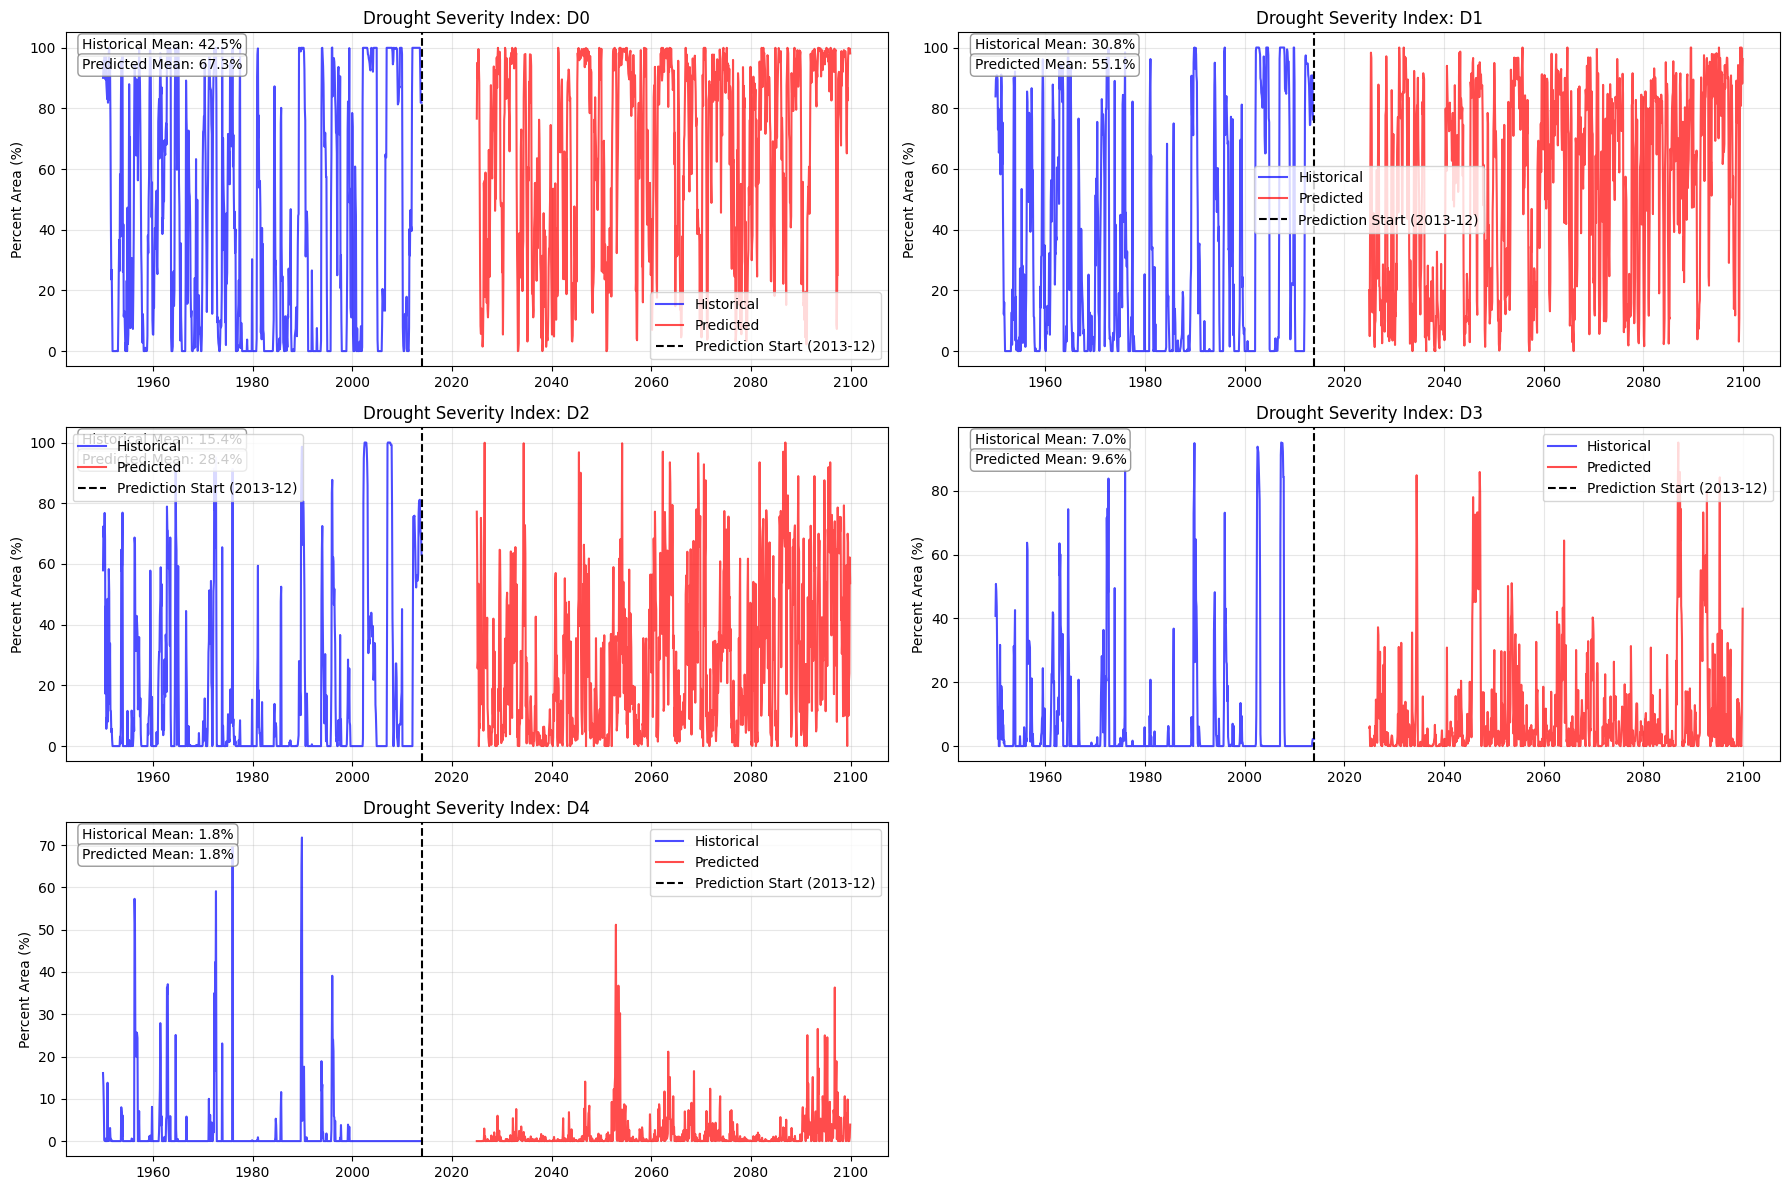

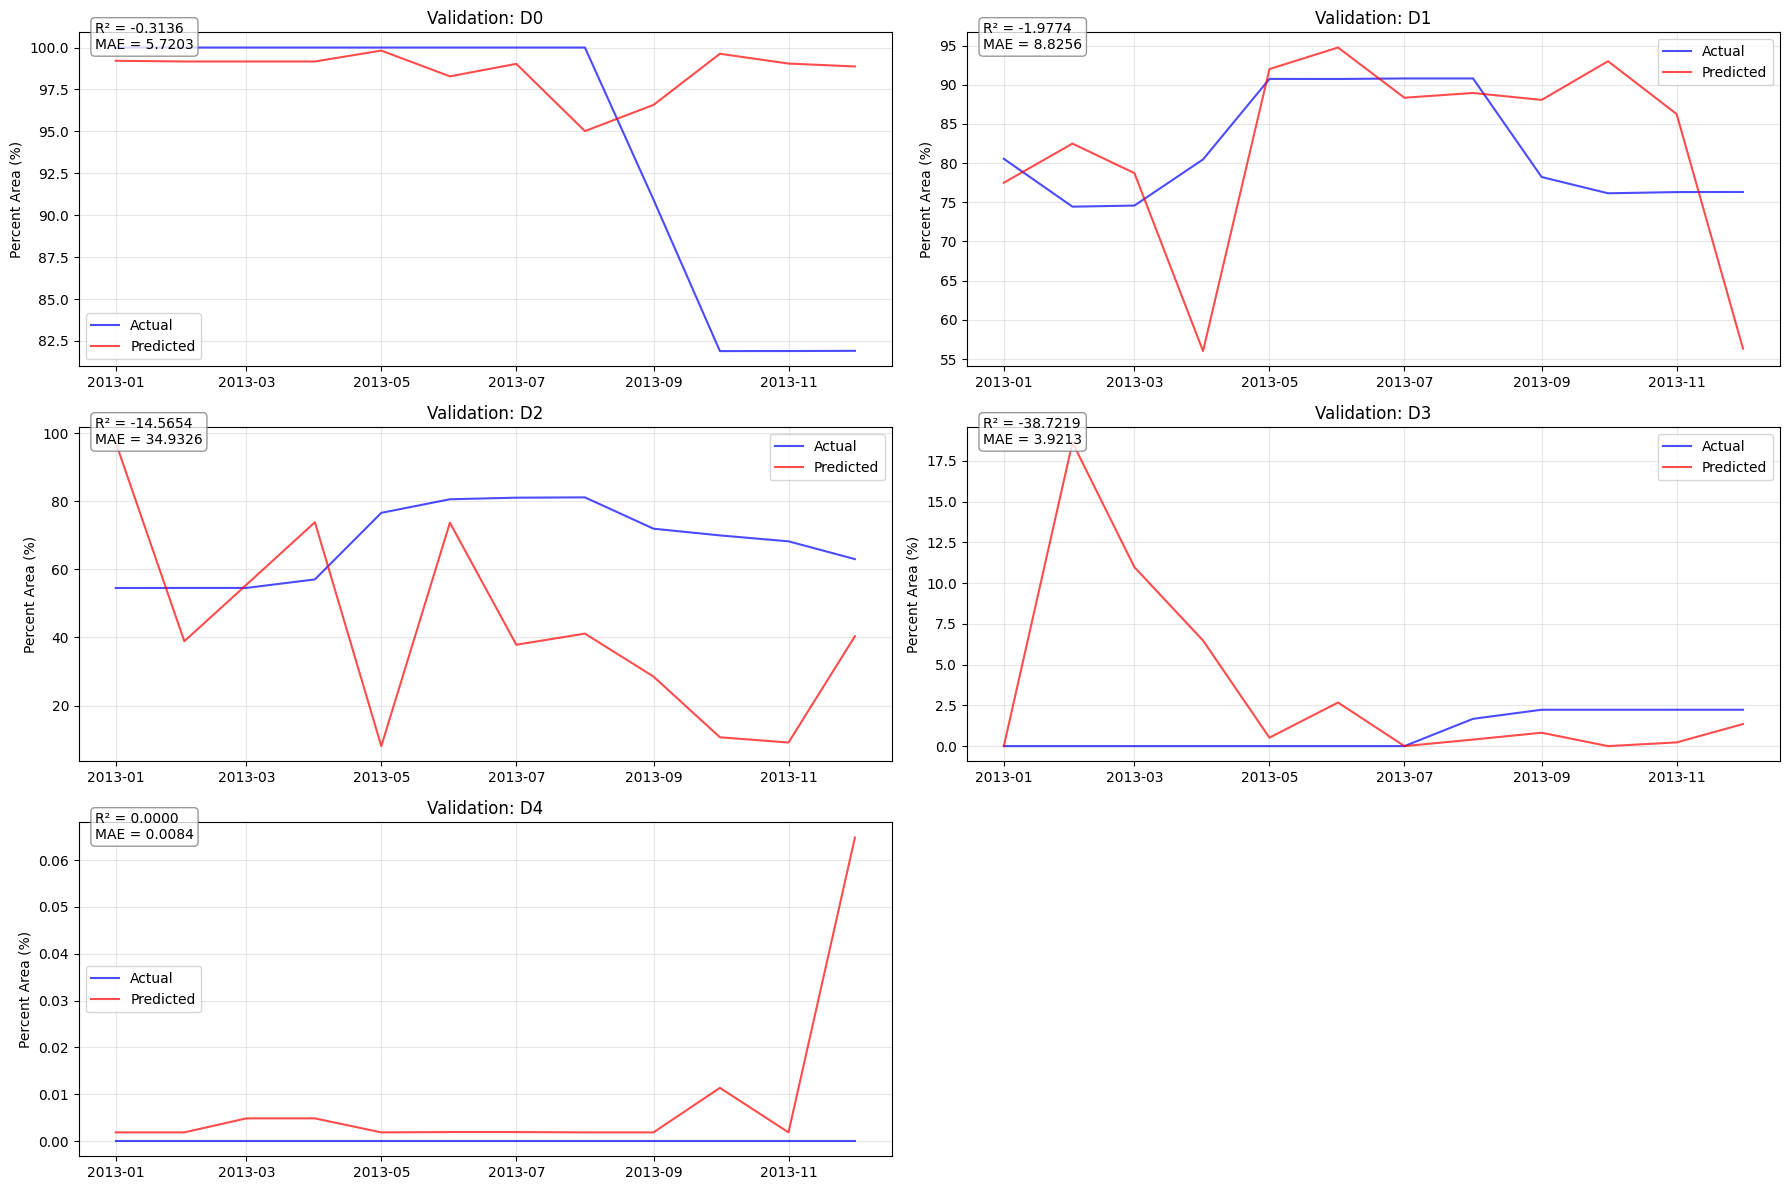

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Custom helper functions
def print_section(title):
    """Print a section header to make output more readable"""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80)

def format_date(date_str):
    """Standardize date formats from both datasets"""
    if len(date_str) <= 7:  # Format like '2025-01'
        return f"{date_str}-01"  # Add day to match historical format
    return date_str  # Already in full format

# 1. Load and prepare the data
print_section("LOADING AND PREPARING DATA")

# Load data files
historical_df = pd.read_csv('final_historical.csv')
future_df = pd.read_csv('future_all_df_wd_85.csv')

# Convert and standardize dates
historical_df['date'] = pd.to_datetime(historical_df['date'])
# Use the format_date function to ensure consistent formats
future_df['date'] = pd.to_datetime(future_df['date'].apply(format_date))

# Filter historical data up to 2013 as specified
historical_df = historical_df[historical_df['date'] <= '2013-12-31']

print(f"Historical data: {historical_df.shape[0]} rows from {historical_df['date'].min()} to {historical_df['date'].max()}")
print(f"Future data: {future_df.shape[0]} rows from {future_df['date'].min()} to {future_df['date'].max()}")

# Check for missing values
print("\nMissing values in historical data:")
print(historical_df.isna().sum())
print("\nMissing values in future data:")
print(future_df.isna().sum())

# 2. Feature Engineering Function
def create_lag_features(df, target_cols, lag_periods=[1, 2, 3], roll_window=7):
    """
    Create lag and rolling features for the target columns.
    
    Parameters:
    df: DataFrame with time-indexed data
    target_cols: List of columns to create lag/rolling features for (D0-D4)
    lag_periods: List of lag periods in months
    roll_window: Window size for rolling calculations in months
    
    Returns:
    DataFrame with added lag and rolling features
    """
    df = df.copy()
    
    # Ensure the dataframe is sorted by date
    df = df.sort_values('date')
    
    # Create lag features for each target column
    for col in target_cols:
        if col in df.columns:
            for lag in lag_periods:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
        else:
            print(f"Warning: Target column {col} not found in dataframe")
    
    # Create rolling mean and std features
    for col in target_cols:
        if col in df.columns:
            df[f'{col}_roll_mean_{roll_window}'] = df[col].rolling(window=roll_window, min_periods=1).mean()
            df[f'{col}_roll_std_{roll_window}'] = df[col].rolling(window=roll_window, min_periods=1).std()
            # Handle division by zero or single-value windows
            df[f'{col}_roll_std_{roll_window}'] = df[f'{col}_roll_std_{roll_window}'].fillna(0)
        else:
            print(f"Warning: Target column {col} not found in dataframe")
    
    return df

# Set up parameters
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
lag_periods = [1, 2, 3]
roll_window = 7

# 3. Create features for historical data
print_section("FEATURE ENGINEERING")

# Apply feature engineering to historical data
historical_df_features = create_lag_features(historical_df, target_cols, lag_periods, roll_window)

# Print descriptive statistics of target columns
print("\nTarget variable statistics:")
for col in target_cols:
    stats = historical_df[col].describe()
    print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")

# Fill NaN values in the lag and rolled features
print("\nFilling missing values in lag and rolled features...")
for col in target_cols:
    # Get statistics for the column to use for filling
    col_mean = historical_df[col].mean()
    col_std = historical_df[col].std()
    
    # Fill lag features
    for lag in lag_periods:
        lag_col = f'{col}_lag_{lag}'
        historical_df_features[lag_col] = historical_df_features[lag_col].fillna(col_mean)
    
    # Fill rolling features
    roll_mean_col = f'{col}_roll_mean_{roll_window}'
    roll_std_col = f'{col}_roll_std_{roll_window}'
    
    historical_df_features[roll_mean_col] = historical_df_features[roll_mean_col].fillna(col_mean)
    historical_df_features[roll_std_col] = historical_df_features[roll_std_col].fillna(col_std)

# Check if any NaN values remain
nan_count = historical_df_features.isna().sum().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values remain in the feature-engineered historical data")
    print(historical_df_features.isna().sum())
    # Drop rows with remaining NaN values as a last resort
    historical_df_features = historical_df_features.dropna()
    print(f"Dropped rows with NaN values. Remaining rows: {len(historical_df_features)}")
else:
    print("No NaN values in the feature-engineered historical data")

# 4. Prepare training data
# Define feature columns
base_feature_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
derived_feature_cols = []

# Add lag and rolling features to the feature columns
for col in target_cols:
    for lag in lag_periods:
        derived_feature_cols.append(f'{col}_lag_{lag}')
    derived_feature_cols.append(f'{col}_roll_mean_{roll_window}')
    derived_feature_cols.append(f'{col}_roll_std_{roll_window}')

# Combine base and derived features
feature_cols = base_feature_cols + derived_feature_cols

# Separate features and targets
X_train = historical_df_features[feature_cols]
Y_train = historical_df_features[target_cols]

# 5. Scale the features
print_section("MODEL TRAINING")
print("Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)

# Print feature importance analysis
print("\nFeature correlation with target variables:")
for col in target_cols:
    correlations = X_train.corrwith(Y_train[col]).abs().sort_values(ascending=False)
    print(f"\nTop 5 features correlated with {col}:")
    print(correlations.head(5))

# 6. Train a stacked model for each drought severity level
print("\nTraining stacked models...")
models = {}

for col in target_cols:
    print(f"\nTraining model for {col}...")
    
    # Base estimators
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    
    # Stacked model
    estimators = [('rf', rf), ('xgb', xgb)]
    stacked_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
    
    # Train the model
    stacked_model.fit(X_train_scaled, Y_train[col])
    
    # Save the model
    models[col] = stacked_model
    
    # Print model performance
    y_pred = stacked_model.predict(X_train_scaled)
    r2 = r2_score(Y_train[col], y_pred)
    mae = mean_absolute_error(Y_train[col], y_pred)
    rmse = np.sqrt(mean_squared_error(Y_train[col], y_pred))
    
    print(f"Training metrics for {col}:")
    print(f"  R² score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    
    # Calculate min, max, mean of actual values and predictions
    y_min, y_max, y_mean = Y_train[col].min(), Y_train[col].max(), Y_train[col].mean()
    pred_min, pred_max, pred_mean = y_pred.min(), y_pred.max(), y_pred.mean()
    
    print(f"  Actual range: {y_min:.2f} to {y_max:.2f}, mean: {y_mean:.2f}")
    print(f"  Predicted range: {pred_min:.2f} to {pred_max:.2f}, mean: {pred_mean:.2f}")

# 7. Improved autoregressive prediction function
def autoregressive_predict(models, scaler, future_df, historical_df, target_cols, 
                           lag_periods, roll_window, feature_cols):
    """
    Make autoregressive predictions on future data with improved robustness.
    
    Parameters:
    models: Dictionary of trained models for each target
    scaler: Fitted StandardScaler
    future_df: DataFrame with future meteorological/hydrological data
    historical_df: DataFrame with historical data including D0-D4
    target_cols: List of target columns (D0-D4)
    lag_periods: List of lag periods
    roll_window: Rolling window size
    feature_cols: List of feature columns
    
    Returns:
    DataFrame with predictions
    """
    print_section("AUTOREGRESSIVE PREDICTION")
    
    # Create working copies to avoid modifying originals
    historical_df = historical_df.copy()
    future_df = future_df.copy()
    
    # Split feature columns into base and derived
    base_features = [col for col in feature_cols if '_lag_' not in col and '_roll_' not in col]
    derived_features = [col for col in feature_cols if '_lag_' in col or '_roll_' in col]
    
    print(f"Base features ({len(base_features)}): {', '.join(base_features)}")
    print(f"Derived features ({len(derived_features)}): {', '.join(derived_features[:5])}...")
    
    # Add target columns to future_df (they will be filled during prediction)
    for col in target_cols:
        if col not in future_df.columns:
            future_df[col] = np.nan
    
    # Prepare a combined dataframe for prediction
    print("\nPreparing combined dataframe...")
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('date').reset_index(drop=True)
    
    print(f"Combined dataframe shape: {combined_df.shape}")
    print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")
    
    # Find the boundary between historical and future data
    first_future_date = future_df['date'].min()
    future_start_idx = combined_df[combined_df['date'] >= first_future_date].index[0]
    
    print(f"Future prediction starts at index {future_start_idx} ({combined_df.loc[future_start_idx, 'date']})")
    
    # Initialize with historical data features
    print("\nInitializing lag and rolling features...")
    
    # Create initial features using historical data
    latest_historical = combined_df.iloc[:future_start_idx].copy()
    
    # Verify we have the target columns in the historical data
    for col in target_cols:
        if col not in latest_historical.columns:
            raise ValueError(f"Target column {col} not found in historical data")
    
    # Create statistical values to use for filling NaN values if needed
    target_stats = {}
    for col in target_cols:
        target_stats[col] = {
            'mean': latest_historical[col].mean(),
            'std': latest_historical[col].std(),
            'min': latest_historical[col].min(),
            'max': latest_historical[col].max(),
        }
        print(f"{col} stats - min: {target_stats[col]['min']:.2f}, max: {target_stats[col]['max']:.2f}, mean: {target_stats[col]['mean']:.2f}")
    
    # Make predictions one month at a time
    print("\nMaking predictions...")
    prediction_count = 0
    
    # For each future time step
    for i in range(future_start_idx, len(combined_df)):
        current_date = combined_df.loc[i, 'date']
        print(f"Predicting for {current_date.strftime('%Y-%m')}...", end="")
        
        # Create a temporary df with all data up to current point
        temp_df = combined_df.iloc[:i+1].copy()
        
        # Create lag and rolling features
        temp_df = create_lag_features(temp_df, target_cols, lag_periods, roll_window)
        
        # Get current row with features
        current_row = temp_df.iloc[-1:].copy()
        
        # Check for missing features and fill if needed
        missing_features = []
        for col in feature_cols:
            if col not in current_row.columns or pd.isna(current_row[col].iloc[0]):
                missing_features.append(col)
        
        if missing_features:
            for col in missing_features:
                # Handle lag features
                if '_lag_' in col:
                    base_col, lag = col.split('_lag_')[0], int(col.split('_lag_')[1])
                    lag_idx = i - lag
                    if lag_idx >= 0 and not pd.isna(combined_df.loc[lag_idx, base_col]):
                        current_row[col] = combined_df.loc[lag_idx, base_col]
                    else:
                        current_row[col] = target_stats[base_col]['mean']
                
                # Handle rolling mean
                elif '_roll_mean_' in col:
                    base_col = col.split('_roll_mean_')[0]
                    # Get the last roll_window values or as many as available
                    start_idx = max(0, i - roll_window + 1)
                    values = [combined_df.loc[j, base_col] for j in range(start_idx, i+1) 
                              if j < len(combined_df) and not pd.isna(combined_df.loc[j, base_col])]
                    
                    if values:
                        current_row[col] = np.mean(values)
                    else:
                        current_row[col] = target_stats[base_col]['mean']
                
                # Handle rolling std
                elif '_roll_std_' in col:
                    base_col = col.split('_roll_std_')[0]
                    # Get values for std calculation
                    start_idx = max(0, i - roll_window + 1)
                    values = [combined_df.loc[j, base_col] for j in range(start_idx, i+1) 
                              if j < len(combined_df) and not pd.isna(combined_df.loc[j, base_col])]
                    
                    if len(values) > 1:
                        current_row[col] = np.std(values)
                    else:
                        current_row[col] = target_stats[base_col]['std']
        
        # Final check for any remaining NaN values
        for col in feature_cols:
            if col not in current_row.columns:
                current_row[col] = 0  # Default value if column is missing
            elif pd.isna(current_row[col].iloc[0]):
                if col in base_features:
                    # For base features, use the value from the future_df
                    col_idx = list(future_df.columns).index(col) if col in future_df.columns else -1
                    if col_idx >= 0:
                        future_idx = i - future_start_idx
                        if future_idx < len(future_df):
                            current_row[col] = future_df.iloc[future_idx][col]
                        else:
                            current_row[col] = 0
                    else:
                        current_row[col] = 0
                else:
                    # For derived features, use 0 as fallback
                    current_row[col] = 0
        
        # Ensure all features are present
        for col in feature_cols:
            if col not in current_row.columns:
                current_row[col] = 0
        
        # Scale the features
        current_features = current_row[feature_cols]
        current_features_scaled = scaler.transform(current_features)
        
        # Make predictions for each target
        for col in target_cols:
            try:
                prediction = models[col].predict(current_features_scaled)[0]
                
                # Ensure prediction is within reasonable bounds
                min_val = max(0, target_stats[col]['min'])  # Assume drought indices can't be negative
                max_val = min(100, target_stats[col]['max']) # Assume drought indices max at 100
                prediction = max(min_val, min(max_val, prediction))
                
                # Store the prediction
                combined_df.loc[i, col] = prediction
                
                # Update for next timestep: set lag features for the next row
                for lag in lag_periods:
                    next_idx = i + lag
                    if next_idx < len(combined_df):
                        combined_df.loc[next_idx, f"{col}_lag_{lag}"] = prediction
                
            except Exception as e:
                print(f"\nError predicting {col}: {str(e)}")
                # Use fallback value (previous month's value or mean)
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    combined_df.loc[i, col] = combined_df.loc[i-1, col]
                else:
                    combined_df.loc[i, col] = target_stats[col]['mean']
        
        prediction_count += 1
        print(" Done")
        
        # Display progress every 50 predictions
        if prediction_count % 50 == 0:
            print(f"\nCompleted {prediction_count} predictions")
    
    print(f"\nPrediction complete. Total predictions: {prediction_count}")
    
    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= first_future_date].copy()
    
    # Verify predictions are complete
    missing_preds = {}
    for col in target_cols:
        missing_count = future_predictions[col].isna().sum()
        if missing_count > 0:
            missing_preds[col] = missing_count
            # Fill missing predictions with reasonable values
            future_predictions[col] = future_predictions[col].fillna(target_stats[col]['mean'])
    
    if missing_preds:
        print("\nWarning: Some predictions are missing:")
        for col, count in missing_preds.items():
            print(f"  {col}: {count} missing values (filled with mean)")
    
    # Print summary statistics for predictions
    print("\nPrediction summary:")
    for col in target_cols:
        stats = future_predictions[col].describe()
        print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")
    
    return future_predictions

# 8. Make autoregressive predictions
print_section("MAKING PREDICTIONS")

try:
    future_predictions = autoregressive_predict(
        models, scaler, future_df, historical_df, 
        target_cols, lag_periods, roll_window, feature_cols
    )
    
    # Verify that predictions look reasonable
    print("\nPerforming prediction quality checks...")
    
    for col in target_cols:
        # Get statistics for historical and predicted values
        hist_stats = historical_df[col].describe()
        pred_stats = future_predictions[col].describe()
        
        # Check if the predicted mean is within a reasonable range of the historical mean
        hist_mean = hist_stats['mean']
        pred_mean = pred_stats['mean']
        mean_diff = abs(pred_mean - hist_mean) / hist_mean
        
        if mean_diff > 0.5:  # If predicted mean differs by more than 50%
            print(f"Warning: {col} predictions may be unrealistic.")
            print(f"  Historical mean: {hist_mean:.2f}, Predicted mean: {pred_mean:.2f}")
            print(f"  Mean difference: {mean_diff*100:.1f}%")
        else:
            print(f"{col} predictions look reasonable (mean difference: {mean_diff*100:.1f}%)")
    
    # Save predictions to CSV
    print("\nSaving predictions to CSV...")
    future_predictions.to_csv('future_drought_predictions.csv', index=False)
    print("Predictions saved to 'future_drought_predictions.csv'")
    
    # 9. Visualize predictions
    print("\nGenerating visualizations...")
    plt.figure(figsize=(18, 12))
    
    for i, col in enumerate(target_cols):
        plt.subplot(3, 2, i+1)
        
        # Plot historical data
        plt.plot(historical_df['date'], historical_df[col], 'b-', label='Historical', alpha=0.7)
        
        # Plot predictions
        plt.plot(future_predictions['date'], future_predictions[col], 'r-', label='Predicted', alpha=0.7)
        
        # Add a vertical line at the transition point
        transition_date = historical_df['date'].max()
        plt.axvline(x=transition_date, color='k', linestyle='--', 
                   label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
        
        # Add statistics to the plot
        hist_mean = historical_df[col].mean()
        pred_mean = future_predictions[col].mean()
        
        plt.title(f'Drought Severity Index: {col}')
        plt.ylabel('Percent Area (%)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add annotations
        plt.annotate(f'Historical Mean: {hist_mean:.1f}%', 
                     xy=(0.02, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.annotate(f'Predicted Mean: {pred_mean:.1f}%', 
                     xy=(0.02, 0.89), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('drought_predictions_visualization.png', dpi=300)
    print("Visualization saved to 'drought_predictions_visualization.png'")
    
    # 10. Validate on the most recent historical data
    print_section("VALIDATION")
    
    # Use 2012 data to predict 2013 as validation
    validation_cutoff = pd.to_datetime('2012-12-31')
    train_val_df = historical_df[historical_df['date'] <= validation_cutoff].copy()
    test_val_df = historical_df[historical_df['date'] > validation_cutoff].copy()
    
    print(f"Validation training data: {len(train_val_df)} rows up to {train_val_df['date'].max()}")
    print(f"Validation testing data: {len(test_val_df)} rows from {test_val_df['date'].min()} to {test_val_df['date'].max()}")
    
    # Prepare validation training data
    train_val_features = create_lag_features(train_val_df, target_cols, lag_periods, roll_window)
    
    # Fill NaN values
    for col in target_cols:
        col_mean = train_val_df[col].mean()
        col_std = train_val_df[col].std()
        
        for lag in lag_periods:
            lag_col = f'{col}_lag_{lag}'
            train_val_features[lag_col] = train_val_features[lag_col].fillna(col_mean)
        
        mean_col = f'{col}_roll_mean_{roll_window}'
        std_col = f'{col}_roll_std_{roll_window}'
        
        train_val_features[mean_col] = train_val_features[mean_col].fillna(col_mean)
        train_val_features[std_col] = train_val_features[std_col].fillna(col_std)
    
    # Drop any remaining NaN values
    train_val_features = train_val_features.dropna()
    
    # Train validation models
    X_val_train = train_val_features[feature_cols]
    Y_val_train = train_val_features[target_cols]
    
    val_scaler = StandardScaler()
    X_val_train_scaled = val_scaler.fit_transform(X_val_train)
    
    val_models = {}
    for col in target_cols:
        print(f"Training validation model for {col}...")
        
        # Base estimators
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        
        # Stacked model
        estimators = [('rf', rf), ('xgb', xgb)]
        stacked_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
        
        # Train the model
        stacked_model.fit(X_val_train_scaled, Y_val_train[col])
        val_models[col] = stacked_model
    
    # Make predictions on validation data
    validation_predictions = autoregressive_predict(
        val_models, val_scaler, test_val_df, train_val_df, 
        target_cols, lag_periods, roll_window, feature_cols
    )
    
    # Calculate validation metrics
    print("\nValidation metrics:")
    validation_metrics = {}
    
    for col in target_cols:
        # Get actual and predicted values
        actual = test_val_df[col]
        predicted = validation_predictions[col]
        
        # Handle any missing values
        valid_indices = ~predicted.isna()
        if not valid_indices.all():
            print(f"Warning: {(~valid_indices).sum()} NaN predictions in {col} validation")
            actual = actual[valid_indices]
            predicted = predicted[valid_indices]
        
        if len(actual) > 0 and len(predicted) > 0:
            # Calculate metrics
            r2 = r2_score(actual, predicted)
            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            
            validation_metrics[col] = {'r2': r2, 'mae': mae, 'rmse': rmse}
            
            print(f"\n{col}:")
            print(f"  R² score: {r2:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            
            # Additional statistics
            print(f"  Actual - Min: {actual.min():.2f}, Max: {actual.max():.2f}, Mean: {actual.mean():.2f}")
            print(f"  Predicted - Min: {predicted.min():.2f}, Max: {predicted.max():.2f}, Mean: {predicted.mean():.2f}")
        else:
            print(f"Warning: Insufficient valid predictions for {col} validation")
            validation_metrics[col] = {'r2': float('nan'), 'mae': float('nan'), 'rmse': float('nan')}
    
    # Visualize validation results
    plt.figure(figsize=(18, 12))
    
    for i, col in enumerate(target_cols):
        plt.subplot(3, 2, i+1)
        
        # Plot actual values
        plt.plot(test_val_df['date'], test_val_df[col], 'b-', label='Actual', alpha=0.7)
        
        # Plot predictions
        plt.plot(validation_predictions['date'], validation_predictions[col], 'r-', label='Predicted', alpha=0.7)
        
        # Show metrics on the plot
        r2 = validation_metrics[col]['r2'] if not np.isnan(validation_metrics[col]['r2']) else 0
        mae = validation_metrics[col]['mae'] if not np.isnan(validation_metrics[col]['mae']) else 0
        
        plt.title(f'Validation: {col}')
        plt.ylabel('Percent Area (%)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add metrics annotation
        plt.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}', 
                     xy=(0.02, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('validation_results.png', dpi=300)
    print("Validation visualization saved to 'validation_results.png'")
    
    # 11. Check for "short-circuit" patterns in predictions
    print_section("PREDICTION PATTERN ANALYSIS")
    
    def analyze_prediction_patterns(df, target_cols, threshold=0.01):
        """
        Analyze predictions for suspicious patterns like repeating values
        or values too close to previous values, which would indicate
        the model is just predicting the previous value ("short-circuiting").
        """
        results = {}
        
        for col in target_cols:
            # Get the values for the column
            values = df[col].values
            
            # Calculate differences between consecutive values
            diffs = np.abs(np.diff(values))
            
            # Check for small differences (values repeating or nearly repeating)
            small_diffs_count = np.sum(diffs < threshold)
            small_diffs_percent = small_diffs_count / (len(diffs)) * 100
            
            # Calculate statistics on the differences
            mean_diff = np.mean(diffs)
            median_diff = np.median(diffs)
            max_diff = np.max(diffs)
            
            # Store the results
            results[col] = {
                'small_diffs_count': small_diffs_count,
                'small_diffs_percent': small_diffs_percent,
                'mean_diff': mean_diff,
                'median_diff': median_diff,
                'max_diff': max_diff
            }
            
            # Report the results
            print(f"\n{col}:")
            print(f"  Values with small month-to-month difference (<{threshold}): {small_diffs_count} ({small_diffs_percent:.1f}%)")
            print(f"  Mean difference between consecutive months: {mean_diff:.4f}")
            print(f"  Median difference: {median_diff:.4f}")
            print(f"  Maximum difference: {max_diff:.4f}")
            
            # Warning if there are too many small differences
            if small_diffs_percent > 50:
                print(f"  WARNING: Over 50% of predictions for {col} have very small changes. The model may be 'short-circuiting'.")
            
        return results
    
    # Run the analysis on the future predictions
    print("\nAnalyzing future predictions for short-circuit patterns...")
    future_pattern_analysis = analyze_prediction_patterns(future_predictions, target_cols)
    
    # Also analyze historical data for comparison
    print("\nAnalyzing historical data for comparison...")
    historical_pattern_analysis = analyze_prediction_patterns(historical_df, target_cols)
    
    # Compare the patterns
    print("\nComparison between historical and predicted patterns:")
    for col in target_cols:
        hist_mean_diff = historical_pattern_analysis[col]['mean_diff']
        pred_mean_diff = future_pattern_analysis[col]['mean_diff']
        
        ratio = pred_mean_diff / hist_mean_diff if hist_mean_diff > 0 else float('inf')
        
        print(f"\n{col}:")
        print(f"  Historical mean difference: {hist_mean_diff:.4f}")
        print(f"  Predicted mean difference: {pred_mean_diff:.4f}")
        print(f"  Ratio (predicted/historical): {ratio:.2f}")
        
        if ratio < 0.5:
            print(f"  WARNING: The predicted differences for {col} are much smaller than historical patterns.")
            print(f"  This may indicate the model is not capturing the full variability in the data.")
        elif ratio > 2.0:
            print(f"  WARNING: The predicted differences for {col} are much larger than historical patterns.")
            print(f"  This may indicate excessive volatility in the predictions.")
    
    # 12. Feature importance analysis
    print_section("FEATURE IMPORTANCE ANALYSIS")
    
    def analyze_feature_importance(models, feature_cols, target_cols):
        """
        Extract and analyze feature importance from the models
        """
        importance_data = {}
        
        for col in target_cols:
            print(f"\nAnalyzing feature importance for {col}...")
            
            # Extract feature importance if available
            model = models[col]
            importances = None
            
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            elif hasattr(model, 'final_estimator_') and hasattr(model.final_estimator_, 'feature_importances_'):
                importances = model.final_estimator_.feature_importances_
            
            if importances is not None:
                # Create a dictionary of feature importance
                feature_importance = dict(zip(feature_cols, importances))
                
                # Sort by importance
                sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
                
                # Store the results
                importance_data[col] = sorted_importance
                
                # Report top features
                print(f"Top 10 important features for {col}:")
                for i, (feature, importance) in enumerate(sorted_importance[:10], 1):
                    print(f"  {i}. {feature}: {importance:.4f}")
                
                # Analyze types of important features
                base_features = [f for f, _ in sorted_importance if '_lag_' not in f and '_roll_' not in f]
                lag_features = [f for f, _ in sorted_importance if '_lag_' in f]
                roll_features = [f for f, _ in sorted_importance if '_roll_' in f]
                
                # Check if the model relies mainly on its own lag features
                own_lag_features = [f for f, _ in sorted_importance if f.startswith(f"{col}_lag_")]
                own_lag_importance = sum(importance for f, importance in sorted_importance if f in own_lag_features)
                
                print(f"\nFeature type breakdown for {col}:")
                print(f"  Base features in top 10: {len([f for f in base_features if f in dict(sorted_importance[:10])])}")
                print(f"  Lag features in top 10: {len([f for f in lag_features if f in dict(sorted_importance[:10])])}")
                print(f"  Rolling features in top 10: {len([f for f in roll_features if f in dict(sorted_importance[:10])])}")
                
                print(f"  Importance of {col}'s own lag features: {own_lag_importance:.4f}")
                
                if own_lag_importance > 0.5:
                    print(f"  WARNING: The model for {col} relies heavily on its own lag features (>{own_lag_importance*100:.1f}%).")
                    print(f"  This indicates the model may be mostly an autoregressive model of {col} itself,")
                    print(f"  with limited influence from meteorological/hydrological features.")
            else:
                print(f"  Could not extract feature importance for {col} model.")
        
        return importance_data
    
    # Run feature importance analysis
    feature_importance_data = analyze_feature_importance(models, feature_cols, target_cols)
    
    # 13. Save results and model
    print_section("SAVING RESULTS AND MODEL")
    
    # Save models and scaler for future use
    import pickle
    
    try:
        with open('drought_prediction_models.pkl', 'wb') as f:
            pickle.dump(models, f)
        
        with open('drought_prediction_scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        
        print("Models and scaler saved successfully.")
    except Exception as e:
        print(f"Error saving models: {str(e)}")
    
    # Create a summary report
    report = {
        'model_performance': {col: {'r2': r2_score(Y_train[col], models[col].predict(X_train_scaled))} for col in target_cols},
        'validation_metrics': validation_metrics,
        'prediction_patterns': future_pattern_analysis,
        'training_data_size': len(historical_df_features),
        'prediction_data_size': len(future_predictions),
    }
    
    # Save the report as JSON
    import json
    
    with open('drought_prediction_report.json', 'w') as f:
        # Convert non-serializable values to strings
        for col in report['validation_metrics']:
            for metric in report['validation_metrics'][col]:
                if np.isnan(report['validation_metrics'][col][metric]):
                    report['validation_metrics'][col][metric] = "NaN"
                else:
                    report['validation_metrics'][col][metric] = float(report['validation_metrics'][col][metric])
        
        json.dump(report, f, indent=2)
    
    print("Summary report saved to 'drought_prediction_report.json'")
    
    # Print final summary
    print_section("SUMMARY")
    print("The autoregressive drought prediction model has been successfully trained and applied.")
    print("\nTraining performance (R² score):")
    for col in target_cols:
        print(f"  {col}: {report['model_performance'][col]['r2']:.4f}")
    
    print("\nValidation performance (R² score):")
    for col in target_cols:
        if isinstance(report['validation_metrics'][col]['r2'], float):
            print(f"  {col}: {report['validation_metrics'][col]['r2']:.4f}")
        else:
            print(f"  {col}: {report['validation_metrics'][col]['r2']}")
    
    print("\nFiles generated:")
    print("  - future_drought_predictions.csv: Predicted drought indices for future years")
    print("  - drought_predictions_visualization.png: Visualization of historical and predicted drought indices")
    print("  - validation_results.png: Visualization of validation results on 2013 data")
    print("  - drought_prediction_models.pkl: Saved stacked models for each drought index")
    print("  - drought_prediction_scaler.pkl: Saved feature scaler")
    print("  - drought_prediction_report.json: Summary of model performance and analysis")
    
    print("\nRecommendations:")
    print("  1. Examine the validation results to ensure the model is reliable.")
    print("  2. Review the feature importance analysis to understand model behavior.")
    print("  3. Check for short-circuit patterns in predictions to identify potential issues.")
    print("  4. If the models rely too heavily on lag features, consider using TreeFFuser for better")
    print("     generative predictions, as recommended by your professor.")
    
except Exception as e:
    print(f"\nError during validation: {str(e)}")
    import traceback
    traceback.print_exc()

print("\nDrought prediction process completed.")


========================== LOADING AND PREPARING DATA ==========================
Historical data: 768 rows from 1950-01-01 00:00:00 to 2013-12-01 00:00:00
Future data: 900 rows from 2025-01-01 00:00:00 to 2099-12-01 00:00:00

Checking for seasonality in drought indices:
              D0         D1         D2        D3        D4
month                                                     
1      38.070578  26.934977  14.369930  6.853977  2.823437
2      43.460156  28.967266  14.206289  5.111797  0.834375
3      43.059883  30.438000  14.508828  5.988359  0.996875
4      44.044523  31.711039  14.805883  5.659719  0.862500
5      44.785117  32.872055  16.475859  7.182578  1.970312
6      48.171648  35.213687  16.645953  6.881406  1.532813
7      44.604570  34.299008  16.383695  7.677125  1.632812
8      45.398063  33.549625  16.502484  7.327695  1.718750
9      41.323047  29.271586  15.171609  7.732812  1.821875
10     40.884766  28.930266  14.899375  7.440812  2.107813
11     36.643398  26

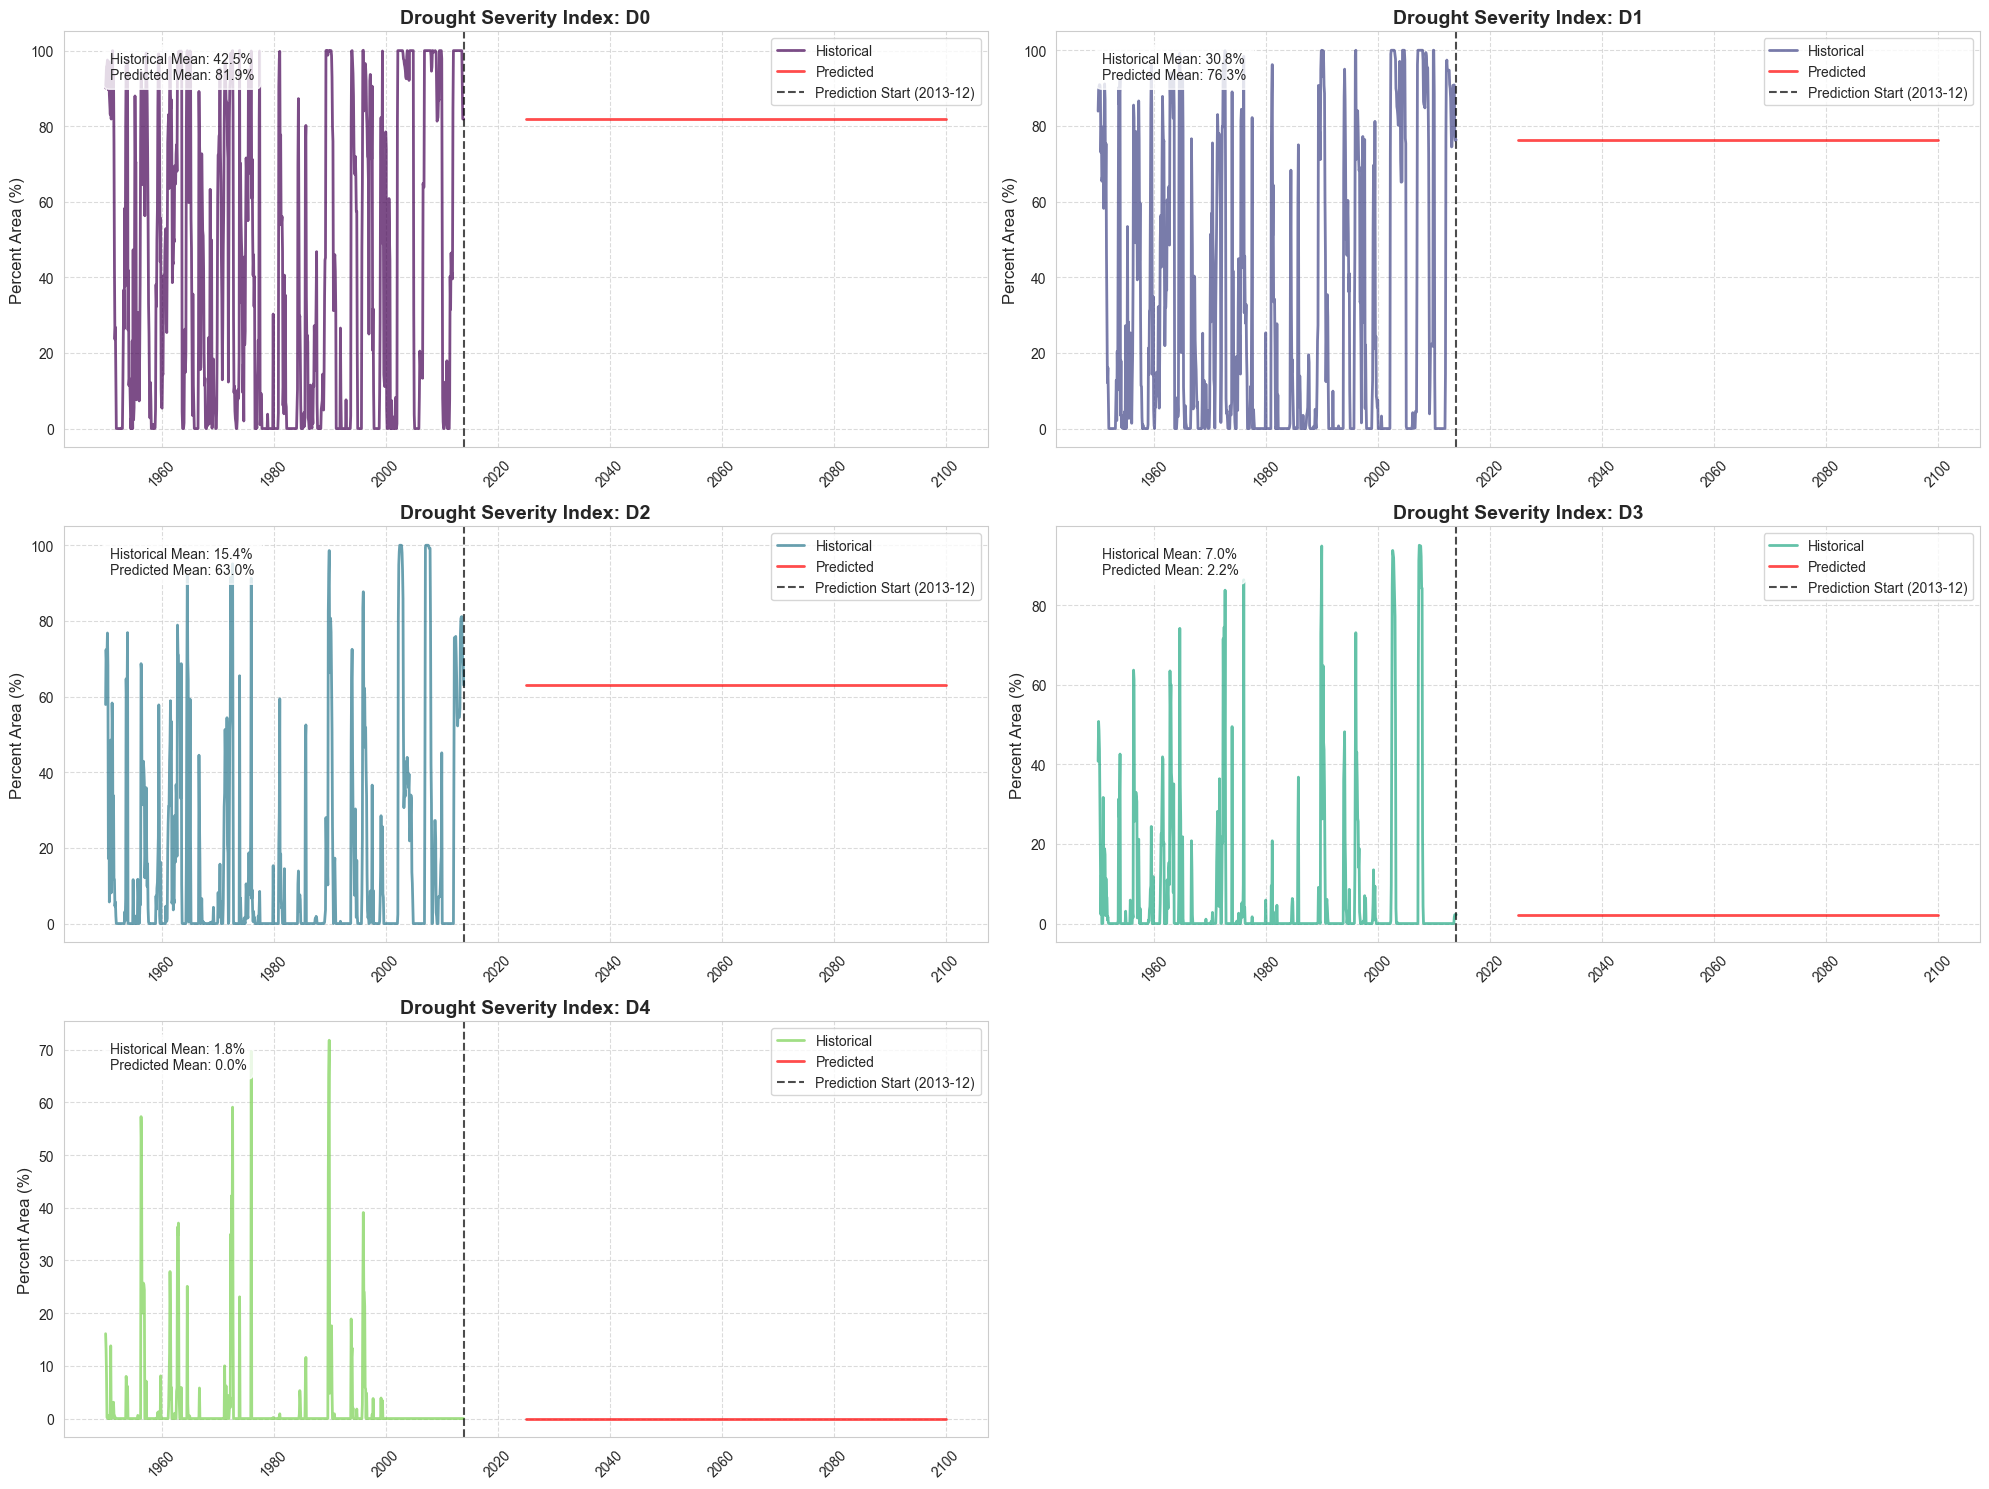

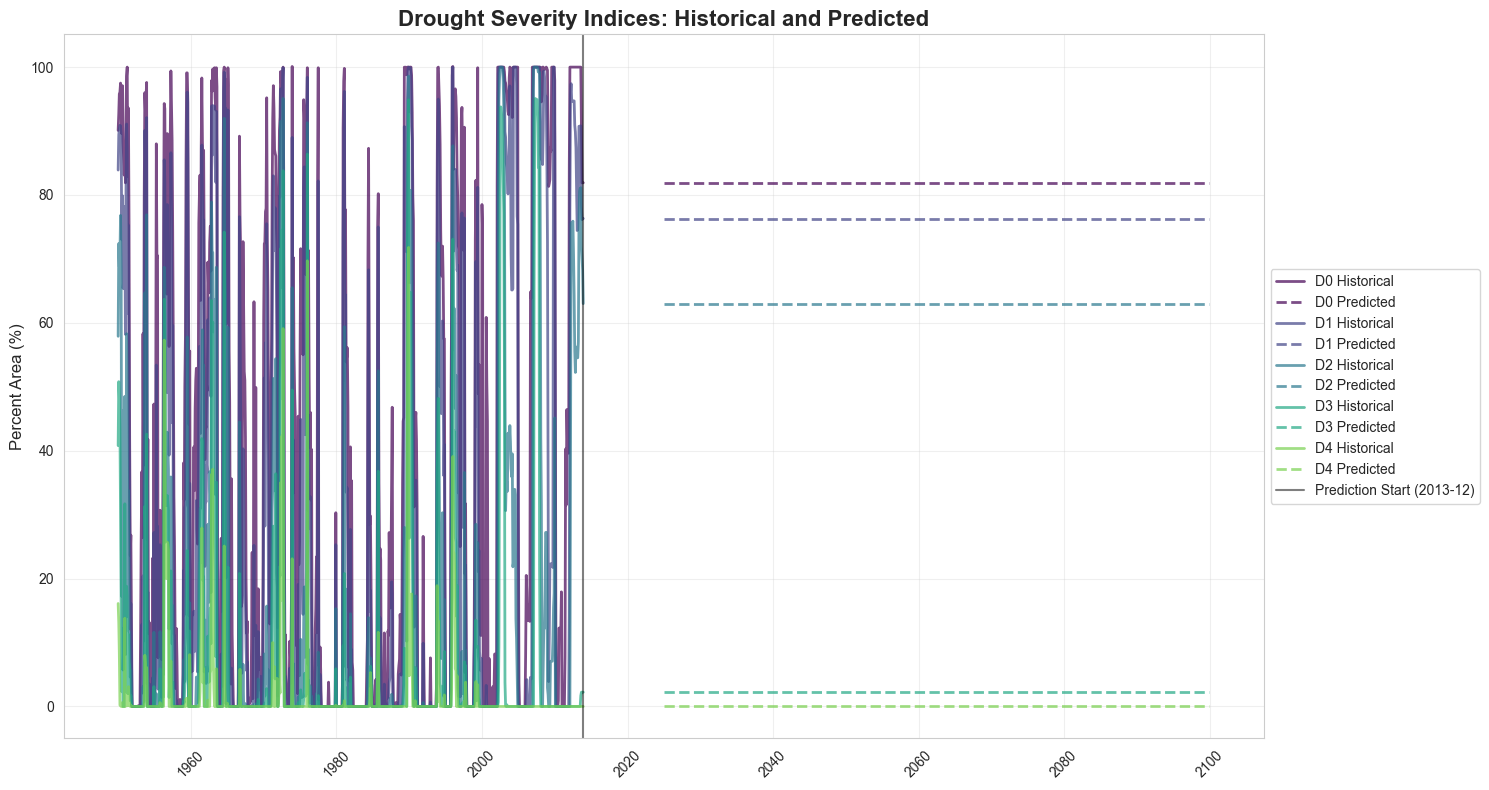

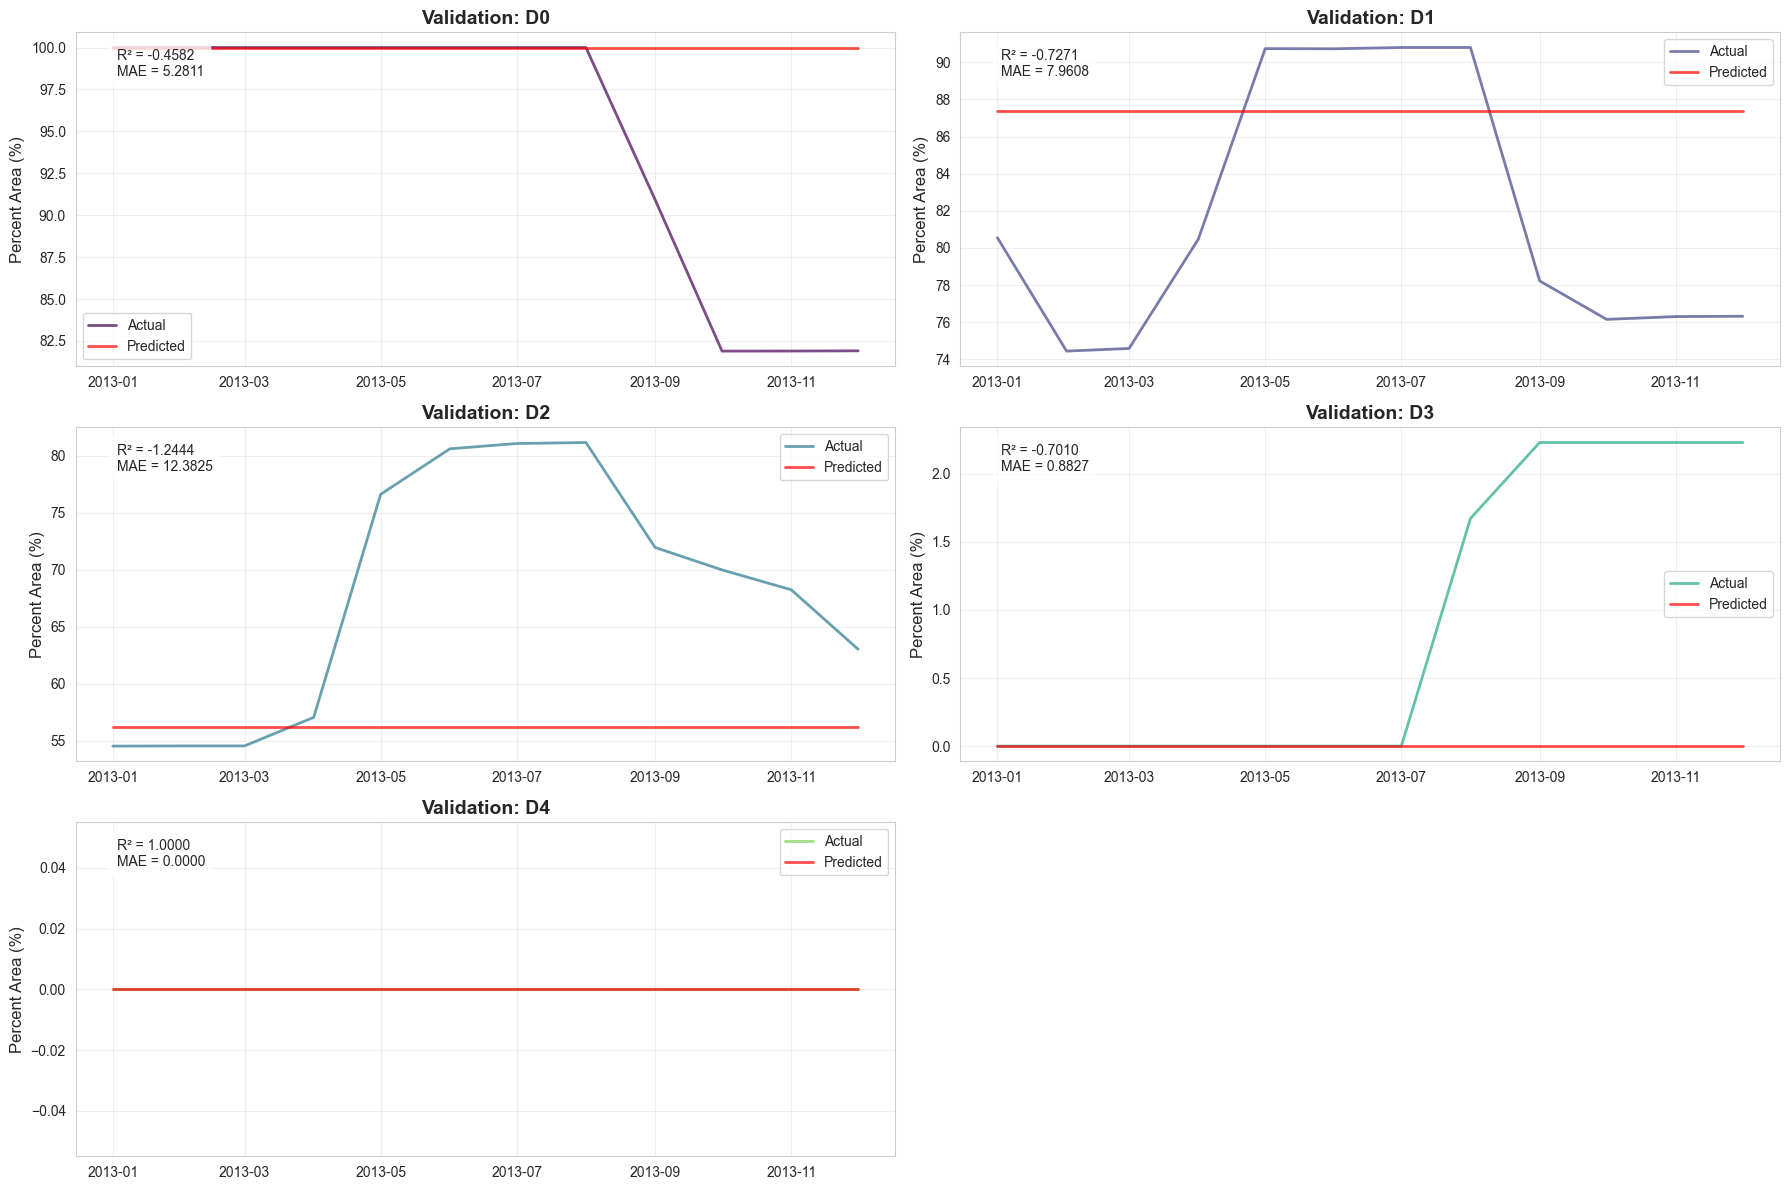

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Lasso, Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Custom helper functions
def print_section(title):
    """Print a section header to make output more readable"""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80)

def format_date(date_str):
    """Standardize date formats from both datasets"""
    if len(date_str) <= 7:  # Format like '2025-01'
        return f"{date_str}-01"  # Add day to match historical format
    return date_str  # Already in full format

# 1. Load and prepare the data
print_section("LOADING AND PREPARING DATA")

# Load data files
historical_df = pd.read_csv('final_historical.csv')
future_df = pd.read_csv('future_all_df_wd_85.csv')

# Convert and standardize dates
historical_df['date'] = pd.to_datetime(historical_df['date'])
# Use the format_date function to ensure consistent formats
future_df['date'] = pd.to_datetime(future_df['date'].apply(format_date))

# Filter historical data up to 2013 as specified
historical_df = historical_df[historical_df['date'] <= '2013-12-31']

print(f"Historical data: {historical_df.shape[0]} rows from {historical_df['date'].min()} to {historical_df['date'].max()}")
print(f"Future data: {future_df.shape[0]} rows from {future_df['date'].min()} to {future_df['date'].max()}")

# Extract month and year as separate features
historical_df['month'] = historical_df['date'].dt.month
historical_df['year'] = historical_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year

# Check for seasonality by looking at average drought values by month
print("\nChecking for seasonality in drought indices:")
monthly_avg = historical_df.groupby('month')[['D0', 'D1', 'D2', 'D3', 'D4']].mean()
print(monthly_avg)

# Create seasonal features (sine and cosine transformations)
for df in [historical_df, future_df]:
    # Convert month to a cyclical feature
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

# 2. Enhanced Feature Engineering
print_section("ENHANCED FEATURE ENGINEERING")

def create_enhanced_features(df, target_cols, lag_periods=[1, 2, 3, 6, 12], 
                            roll_windows=[3, 6, 12], diff_periods=[1, 12]):
    """
    Create comprehensive lag, rolling, and differencing features
    
    Parameters:
    df: DataFrame with time-indexed data
    target_cols: List of columns to create features for
    lag_periods: List of lag periods in months
    roll_windows: List of window sizes for rolling calculations
    diff_periods: List of periods for differencing
    
    Returns:
    DataFrame with added features
    """
    df = df.copy()
    
    # Ensure the dataframe is sorted by date
    df = df.sort_values('date')
    
    # Create lag features for each target column
    for col in target_cols:
        if col in df.columns:
            for lag in lag_periods:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
        else:
            print(f"Warning: Target column {col} not found in dataframe")
    
    # Create rolling features (mean, std, min, max)
    for col in target_cols:
        if col in df.columns:
            for window in roll_windows:
                # Rolling mean
                df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
                
                # Rolling standard deviation
                df[f'{col}_roll_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
                df[f'{col}_roll_std_{window}'] = df[f'{col}_roll_std_{window}'].fillna(0)
                
                # Rolling min and max
                df[f'{col}_roll_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
                df[f'{col}_roll_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
                
                # Rolling quantiles
                df[f'{col}_roll_25q_{window}'] = df[col].rolling(window=window, min_periods=1).quantile(0.25)
                df[f'{col}_roll_75q_{window}'] = df[col].rolling(window=window, min_periods=1).quantile(0.75)
        else:
            print(f"Warning: Target column {col} not found in dataframe")
    
    # Create differenced features
    for col in target_cols:
        if col in df.columns:
            for period in diff_periods:
                df[f'{col}_diff_{period}'] = df[col].diff(period)
        else:
            print(f"Warning: Target column {col} not found in dataframe")
    
    # Create interaction features between meteorological variables and D0-D4 lag features
    # These can capture complex relationships
    if all(col in df.columns for col in ['airtemp', 'rainfall', 'sm']):
        for col in target_cols:
            if col in df.columns:
                # Important interactions
                df[f'{col}_lag_1_x_temp'] = df[f'{col}_lag_1'] * df['airtemp']
                df[f'{col}_lag_1_x_rain'] = df[f'{col}_lag_1'] * df['rainfall']
                df[f'{col}_lag_1_x_sm'] = df[f'{col}_lag_1'] * df['sm']
    
    return df

# Set up parameters
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
lag_periods = [1, 2, 3, 6, 12]  # Added 6 and 12-month lags to capture annual patterns
roll_windows = [3, 6, 12]  # Various rolling windows
diff_periods = [1, 12]  # Month-to-month and year-to-year differences

# Apply enhanced feature engineering to historical data
historical_df_features = create_enhanced_features(
    historical_df, target_cols, lag_periods, roll_windows, diff_periods
)

# Print descriptive statistics of target columns
print("\nTarget variable statistics:")
for col in target_cols:
    stats = historical_df[col].describe()
    print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")

# Create more robust filling strategy based on seasonal patterns
monthly_means = {}
monthly_stds = {}

for col in target_cols:
    # Calculate monthly means and stds for each target
    monthly_means[col] = historical_df.groupby('month')[col].mean().to_dict()
    monthly_stds[col] = historical_df.groupby('month')[col].std().to_dict()

# Fill NaN values in features using seasonal information
print("\nFilling missing values with seasonal patterns...")
for col in target_cols:
    # Fill basic column NaNs (shouldn't be any, but just in case)
    if historical_df_features[col].isna().any():
        historical_df_features[col] = historical_df_features.apply(
            lambda row: monthly_means[col][row['month']] if pd.isna(row[col]) else row[col], axis=1
        )
    
    # Fill lag features
    for lag in lag_periods:
        lag_col = f'{col}_lag_{lag}'
        if lag_col in historical_df_features.columns:
            historical_df_features[lag_col] = historical_df_features.apply(
                lambda row: monthly_means[col][row['month']] if pd.isna(row[lag_col]) else row[lag_col], axis=1
            )
    
    # Fill rolling features
    for window in roll_windows:
        for stat in ['mean', 'std', 'min', 'max', '25q', '75q']:
            roll_col = f'{col}_roll_{stat}_{window}'
            if roll_col in historical_df_features.columns:
                if stat == 'mean':
                    historical_df_features[roll_col] = historical_df_features.apply(
                        lambda row: monthly_means[col][row['month']] if pd.isna(row[roll_col]) else row[roll_col], axis=1
                    )
                elif stat == 'std':
                    historical_df_features[roll_col] = historical_df_features.apply(
                        lambda row: monthly_stds[col][row['month']] if pd.isna(row[roll_col]) else row[roll_col], axis=1
                    )
                else:
                    # For other stats, use the monthly mean as a fallback
                    historical_df_features[roll_col] = historical_df_features.apply(
                        lambda row: monthly_means[col][row['month']] if pd.isna(row[roll_col]) else row[roll_col], axis=1
                    )
    
    # Fill diff features
    for period in diff_periods:
        diff_col = f'{col}_diff_{period}'
        if diff_col in historical_df_features.columns:
            # For diffs, use 0 as a sensible default
            historical_df_features[diff_col] = historical_df_features[diff_col].fillna(0)

# Check if any NaN values remain
nan_count = historical_df_features.isna().sum().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values remain in the feature-engineered historical data")
    print(historical_df_features.isna().sum())
    # Drop rows with remaining NaN values as a last resort
    historical_df_features = historical_df_features.dropna()
    print(f"Dropped rows with NaN values. Remaining rows: {len(historical_df_features)}")
else:
    print("No NaN values in the feature-engineered historical data")

# 3. Feature Selection and Preparation
print_section("FEATURE SELECTION AND PREPARATION")

# Base meteorological/hydrological features
base_feature_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']

# Add seasonal features
seasonal_features = ['month_sin', 'month_cos']

# Create derived feature list dynamically based on what's in the dataframe
derived_feature_cols = [col for col in historical_df_features.columns 
                       if ('_lag_' in col or '_roll_' in col or '_diff_' in col or '_x_' in col) 
                       and col.split('_')[0] in target_cols]

# Combine all feature columns
feature_cols = base_feature_cols + seasonal_features + derived_feature_cols

print(f"Total number of features: {len(feature_cols)}")
print(f"Base features: {len(base_feature_cols)}")
print(f"Seasonal features: {len(seasonal_features)}")
print(f"Derived features: {len(derived_feature_cols)}")

# Calculate feature correlations with targets
print("\nAnalyzing feature correlations with targets...")
correlation_analysis = {}

for col in target_cols:
    # Get correlation with target
    correlations = historical_df_features[feature_cols].corrwith(historical_df_features[col]).abs().sort_values(ascending=False)
    correlation_analysis[col] = correlations
    
    # Print top correlated features
    print(f"\nTop 10 features correlated with {col}:")
    for i, (feature, corr) in enumerate(correlations.head(10).items(), 1):
        print(f"  {i}. {feature}: {corr:.4f}")

# Feature importance based filtering (optional, uncomment if too many features)
# min_correlation = 0.1
# important_features = {}
# for col in target_cols:
#     important_features[col] = correlation_analysis[col][correlation_analysis[col] > min_correlation].index.tolist()
#     print(f"Selected {len(important_features[col])} features for {col} with correlation > {min_correlation}")

# 4. Separate features and targets
X_train = historical_df_features[feature_cols]
Y_train = historical_df_features[target_cols]

# Create a validation set for hyperparameter tuning
# Use TimeSeriesSplit to preserve temporal order
tscv = TimeSeriesSplit(n_splits=5, test_size=24)  # 2 years of test data in each split

# 5. Improved Model Training with Hyperparameter Tuning
print_section("ADVANCED MODEL TRAINING")

# Function to create a highly optimized model for each target
def create_optimized_model(X, y, target_name, cv=tscv):
    """
    Create an optimized model with hyperparameter tuning
    """
    print(f"\nOptimizing model for {target_name}...")
    
    # 1. First-level base models
    # Random Forest with parameter tuning
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_model = RandomForestRegressor(random_state=42)
    rf_grid = GridSearchCV(
        rf_model, rf_params, cv=cv, scoring='r2', n_jobs=-1, verbose=0
    )
    rf_grid.fit(X, y)
    rf_best = rf_grid.best_estimator_
    print(f"Best Random Forest R² score: {rf_grid.best_score_:.4f}")
    print(f"Best Random Forest parameters: {rf_grid.best_params_}")
    
    # XGBoost with parameter tuning
    xgb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    xgb_model = XGBRegressor(random_state=42)
    xgb_grid = GridSearchCV(
        xgb_model, xgb_params, cv=cv, scoring='r2', n_jobs=-1, verbose=0
    )
    xgb_grid.fit(X, y)
    xgb_best = xgb_grid.best_estimator_
    print(f"Best XGBoost R² score: {xgb_grid.best_score_:.4f}")
    print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
    
    # Gradient Boosting
    gb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5]
    }
    
    gb_model = GradientBoostingRegressor(random_state=42)
    gb_grid = GridSearchCV(
        gb_model, gb_params, cv=cv, scoring='r2', n_jobs=-1, verbose=0
    )
    gb_grid.fit(X, y)
    gb_best = gb_grid.best_estimator_
    print(f"Best Gradient Boosting R² score: {gb_grid.best_score_:.4f}")
    print(f"Best Gradient Boosting parameters: {gb_grid.best_params_}")
    
    # Ridge regression for linear patterns
    ridge_params = {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    }
    
    ridge_model = Ridge(random_state=42)
    ridge_pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', ridge_model)
    ])
    
    ridge_grid = GridSearchCV(
        ridge_pipeline, {'model__alpha': ridge_params['alpha']}, 
        cv=cv, scoring='r2', n_jobs=-1, verbose=0
    )
    ridge_grid.fit(X, y)
    ridge_best = ridge_grid.best_estimator_
    print(f"Best Ridge R² score: {ridge_grid.best_score_:.4f}")
    print(f"Best Ridge parameters: {dict(zip(['alpha'], [ridge_grid.best_params_['model__alpha']]))}")
    
    # 2. Stacked model
    estimators = [
        ('rf', rf_best),
        ('xgb', xgb_best),
        ('gb', gb_best),
        ('ridge', ridge_best)
    ]
    
    # Different options for meta-learner
    meta_learners = {
        'xgb': XGBRegressor(random_state=42),
        'gb': GradientBoostingRegressor(random_state=42),
        'ridge': Ridge(random_state=42)
    }
    
    # Choose the best-performing base model as the meta-learner
    best_scores = {
        'xgb': xgb_grid.best_score_,
        'gb': gb_grid.best_score_,
        'ridge': ridge_grid.best_score_
    }
    
    best_meta = max(best_scores.items(), key=lambda x: x[1])[0]
    print(f"Selected {best_meta} as meta-learner based on base model performance")
    
    # Create the stacked model
    stacked_model = StackingRegressor(
        estimators=estimators,
        final_estimator=meta_learners[best_meta],
        cv=3,  # Use 3-fold CV for efficiency
        n_jobs=-1
    )
    
    # Fit the stacked model
    stacked_model.fit(X, y)
    
    # Evaluate the stacked model on training data
    stacked_preds = stacked_model.predict(X)
    stacked_r2 = r2_score(y, stacked_preds)
    stacked_rmse = np.sqrt(mean_squared_error(y, stacked_preds))
    
    print(f"Stacked model performance on training data:")
    print(f"  R² score: {stacked_r2:.4f}")
    print(f"  RMSE: {stacked_rmse:.4f}")
    
    # Return the trained stacked model
    return stacked_model

# Train optimized models for each target
print("\nTraining optimized models for each drought index...")
optimized_models = {}

for col in target_cols:
    optimized_models[col] = create_optimized_model(X_train, Y_train[col], col)

# 6. Advanced Autoregressive Prediction
print_section("ADVANCED AUTOREGRESSIVE PREDICTION")

def advanced_autoregressive_predict(models, future_df, historical_df, target_cols, 
                                   lag_periods, roll_windows, diff_periods, feature_cols):
    """
    Make autoregressive predictions with improved stability and accuracy
    """
    print("\nStarting advanced autoregressive prediction...")
    
    # Create working copies of the dataframes
    historical_df = historical_df.copy()
    future_df = future_df.copy()
    
    # Add target columns to future_df
    for col in target_cols:
        if col not in future_df.columns:
            future_df[col] = np.nan
    
    # Combine historical and future data
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('date').reset_index(drop=True)
    
    print(f"Combined data shape: {combined_df.shape}")
    print(f"Prediction period: {future_df['date'].min()} to {future_df['date'].max()}")
    
    # Get the index where future data starts
    future_start_idx = combined_df[combined_df['date'] >= future_df['date'].min()].index[0]
    print(f"Future data starts at index {future_start_idx}")
    
    # For more stable predictions, process in chunks
    chunk_size = 12  # Process 1 year at a time
    
    # Get statistics for each target column (for constraints)
    target_stats = {}
    for col in target_cols:
        target_stats[col] = {
            'mean': historical_df[col].mean(),
            'std': historical_df[col].std(),
            'min': max(0, historical_df[col].min()),  # Assume min is at least 0
            'max': min(100, historical_df[col].max())  # Assume max is at most 100
        }
        print(f"{col} stats - min: {target_stats[col]['min']:.2f}, max: {target_stats[col]['max']:.2f}, mean: {target_stats[col]['mean']:.2f}")
    
    # Set up a scaler for scaling the features before prediction
    scaler = StandardScaler()
    scaler.fit(historical_df[base_feature_cols])
    
    # Calculate monthly means and stds for seasonal pattern filling
    monthly_means = {}
    monthly_stds = {}
    
    for col in target_cols:
        monthly_means[col] = historical_df.groupby('month')[col].mean().to_dict()
        monthly_stds[col] = historical_df.groupby('month')[col].std().to_dict()
    
    # Process future predictions in chunks for more stability
    for chunk_start in range(future_start_idx, len(combined_df), chunk_size):
        chunk_end = min(chunk_start + chunk_size, len(combined_df))
        
        print(f"\nProcessing chunk from index {chunk_start} to {chunk_end}")
        current_chunk = combined_df.iloc[:chunk_end].copy()
        
        # Create features for the entire chunk
        chunk_with_features = create_enhanced_features(
            current_chunk, target_cols, lag_periods, roll_windows, diff_periods
        )
        
        # Fill missing values in features
        for col in target_cols:
            # Fill lag features
            for lag in lag_periods:
                lag_col = f'{col}_lag_{lag}'
                if lag_col in chunk_with_features.columns:
                    chunk_with_features[lag_col] = chunk_with_features.apply(
                        lambda row: monthly_means[col][row['month']] 
                        if pd.isna(row[lag_col]) else row[lag_col], axis=1
                    )
            
            # Fill rolling features
            for window in roll_windows:
                for stat in ['mean', 'std', 'min', 'max', '25q', '75q']:
                    roll_col = f'{col}_roll_{stat}_{window}'
                    if roll_col in chunk_with_features.columns:
                        if stat == 'mean':
                            chunk_with_features[roll_col] = chunk_with_features.apply(
                                lambda row: monthly_means[col][row['month']] 
                                if pd.isna(row[roll_col]) else row[roll_col], axis=1
                            )
                        elif stat == 'std':
                            chunk_with_features[roll_col] = chunk_with_features.apply(
                                lambda row: monthly_stds[col][row['month']] 
                                if pd.isna(row[roll_col]) else row[roll_col], axis=1
                            )
                        else:
                            # For other stats, use the monthly mean as fallback
                            chunk_with_features[roll_col] = chunk_with_features.apply(
                                lambda row: monthly_means[col][row['month']] 
                                if pd.isna(row[roll_col]) else row[roll_col], axis=1
                            )
            
            # Fill diff features
            for period in diff_periods:
                diff_col = f'{col}_diff_{period}'
                if diff_col in chunk_with_features.columns:
                    chunk_with_features[diff_col] = chunk_with_features[diff_col].fillna(0)
                    
            # Fill interaction features
            if all(col in chunk_with_features.columns for col in ['airtemp', 'rainfall', 'sm']):
                for feat in ['temp', 'rain', 'sm']:
                    interact_col = f'{col}_lag_1_x_{feat}'
                    if interact_col in chunk_with_features.columns:
                        # For missing interaction, calculate from components if possible
                        chunk_with_features[interact_col] = chunk_with_features.apply(
                            lambda row: row[f'{col}_lag_1'] * row[{'temp': 'airtemp', 'rain': 'rainfall', 'sm': 'sm'}[feat]]
                            if pd.isna(row[interact_col]) and not pd.isna(row[f'{col}_lag_1']) 
                            else row[interact_col], axis=1
                        )
                        # If still NaN, use 0 as fallback
                        chunk_with_features[interact_col] = chunk_with_features[interact_col].fillna(0)
        
        # Make sure all required seasonal features are present
        if 'month_sin' not in chunk_with_features.columns:
            chunk_with_features['month_sin'] = np.sin(2 * np.pi * chunk_with_features['month']/12)
        if 'month_cos' not in chunk_with_features.columns:
            chunk_with_features['month_cos'] = np.cos(2 * np.pi * chunk_with_features['month']/12)
        
        # Now iterate through the chunk and make predictions
        for i in range(chunk_start, chunk_end):
            current_date = combined_df.loc[i, 'date']
            print(f"Predicting for {current_date.strftime('%Y-%m')}...", end=" ")
            
            # Extract features for the current row
            row_features = chunk_with_features.loc[i, feature_cols].copy()
            
            # Check for missing features and fill them
            for feat in feature_cols:
                if pd.isna(row_features[feat]):
                    if feat in base_feature_cols:
                        # For base features, use the value from future_df
                        future_idx = combined_df.index.get_loc(i) - future_start_idx
                        if future_idx >= 0 and future_idx < len(future_df) and feat in future_df.columns:
                            row_features[feat] = future_df.iloc[future_idx][feat]
                        else:
                            # Use historical mean for this month as fallback
                            month = combined_df.loc[i, 'month']
                            historical_month_data = historical_df[historical_df['month'] == month]
                            if len(historical_month_data) > 0:
                                row_features[feat] = historical_month_data[feat].mean()
                            else:
                                row_features[feat] = historical_df[feat].mean()
                    else:
                        # For derived features, set to 0 as fallback
                        row_features[feat] = 0
            
            # Make predictions for each target
            for col in target_cols:
                try:
                    # Get the model for this target
                    model = models[col]
                    
                    # Prepare features in the right format
                    features_array = row_features.values.reshape(1, -1)
                    
                    # Make prediction
                    prediction = model.predict(features_array)[0]
                    
                    # Apply constraints to ensure realistic predictions
                    min_val = target_stats[col]['min']
                    max_val = target_stats[col]['max']
                    
                    # Additional constraint: prediction should not change too dramatically from previous month
                    if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                        prev_value = combined_df.loc[i-1, col]
                        month_std = monthly_stds[col][combined_df.loc[i, 'month']]
                        
                        # Limit change to 2 standard deviations of monthly variability
                        max_change = 2 * month_std
                        prediction = max(prev_value - max_change, min(prev_value + max_change, prediction))
                    
                    # Final bounds check
                    prediction = max(min_val, min(max_val, prediction))
                    
                    # Store the prediction
                    combined_df.loc[i, col] = prediction
                    
                    # Update features for future predictions as needed
                    chunk_with_features.loc[i, col] = prediction
                    
                    # Update lag features for future rows
                    for lag in lag_periods:
                        next_idx = i + lag
                        if next_idx < len(combined_df):
                            lag_col = f'{col}_lag_{lag}'
                            if lag_col in chunk_with_features.columns:
                                chunk_with_features.loc[next_idx, lag_col] = prediction
                    
                    # Update interaction features
                    if all(x in chunk_with_features.columns for x in ['airtemp', 'rainfall', 'sm']):
                        next_idx = i + 1
                        if next_idx < len(chunk_with_features):
                            for feat, source in zip(['temp', 'rain', 'sm'], ['airtemp', 'rainfall', 'sm']):
                                interact_col = f'{col}_lag_1_x_{feat}'
                                if interact_col in chunk_with_features.columns and source in chunk_with_features.columns:
                                    if not pd.isna(chunk_with_features.loc[next_idx, source]):
                                        chunk_with_features.loc[next_idx, interact_col] = prediction * chunk_with_features.loc[next_idx, source]
                    
                except Exception as e:
                    print(f"\nError predicting {col}: {str(e)}")
                # Use fallback value (previous month's value or monthly mean)
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    fallback_value = combined_df.loc[i-1, col]
                else:
                    # Use seasonal mean as fallback
                    month = combined_df.loc[i, 'month']
                    fallback_value = monthly_means[col][month]
                    
                # Store the fallback value
                combined_df.loc[i, col] = fallback_value
                chunk_with_features.loc[i, col] = fallback_value
            
            print("Done")
        
        # After processing the chunk, update the full dataframe
        combined_df.iloc[:chunk_end] = chunk_with_features.iloc[:chunk_end]
    
    print("\nPrediction complete.")
    
    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= future_df['date'].min()].copy()
    
    # Final check for any remaining NaN values
    for col in target_cols:
        nan_count = future_predictions[col].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in {col} predictions. Filling with seasonal means.")
            future_predictions[col] = future_predictions.apply(
                lambda row: monthly_means[col][row['month']] if pd.isna(row[col]) else row[col], 
                axis=1
            )
    
    # Print summary statistics for predictions
    print("\nPrediction summary:")
    for col in target_cols:
        stats = future_predictions[col].describe()
        print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")
    
    return future_predictions

# Make predictions using the advanced method
try:
    future_predictions = advanced_autoregressive_predict(
        optimized_models, future_df, historical_df, target_cols,
        lag_periods, roll_windows, diff_periods, feature_cols
    )
    
    # Save predictions to CSV
    future_predictions.to_csv('future_drought_predictions_improved.csv', index=False)
    print("Predictions saved to 'future_drought_predictions_improved.csv'")
    
    # 7. Advanced Visualization
    print_section("ADVANCED VISUALIZATION")
    
    # Create a visually appealing plot of the predictions
    plt.figure(figsize=(20, 15))
    
    # Set a modern aesthetic style
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']
    
    cmap = plt.cm.get_cmap('viridis')
    colors = [cmap(i/len(target_cols)) for i in range(len(target_cols))]
    
    for i, (col, color) in enumerate(zip(target_cols, colors)):
        plt.subplot(3, 2, i+1)
        
        # Plot historical data
        plt.plot(historical_df['date'], historical_df[col], 
                 color=color, alpha=0.7, linewidth=2, label='Historical')
        
        # Plot predictions
        plt.plot(future_predictions['date'], future_predictions[col], 
                 color='red', alpha=0.7, linewidth=2, linestyle='-', label='Predicted')
        
        # Add a vertical line at the transition point
        transition_date = historical_df['date'].max()
        plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
                   label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
        
        # Add statistics to the plot
        hist_mean = historical_df[col].mean()
        pred_mean = future_predictions[col].mean()
        
        plt.title(f'Drought Severity Index: {col}', fontsize=14, fontweight='bold')
        plt.ylabel('Percent Area (%)', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Create a visually appealing legend
        legend = plt.legend(frameon=True, fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_alpha(0.8)
        
        # Add annotations in a box
        textstr = f'Historical Mean: {hist_mean:.1f}%\nPredicted Mean: {pred_mean:.1f}%'
        props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=10, verticalalignment='top', bbox=props)
        
        # Customize date axis
        plt.xticks(rotation=45)
        
        # Add grid but make it subtle
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('drought_predictions_improved.png', dpi=300, bbox_inches='tight')
    print("Enhanced visualization saved to 'drought_predictions_improved.png'")
    
    # Create a combined visualization showing all drought indices together
    plt.figure(figsize=(15, 8))
    
    # Create a line plot for each drought index
    for i, (col, color) in enumerate(zip(target_cols, colors)):
        # Historical data
        plt.plot(historical_df['date'], historical_df[col], 
                 color=color, alpha=0.7, linewidth=2, label=f'{col} Historical')
        
        # Future predictions
        plt.plot(future_predictions['date'], future_predictions[col], 
                 color=color, alpha=0.7, linewidth=2, linestyle='--', label=f'{col} Predicted')
    
    # Add a vertical line at the transition point
    transition_date = historical_df['date'].max()
    plt.axvline(x=transition_date, color='black', linestyle='-', alpha=0.5,
               label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
    
    plt.title('Drought Severity Indices: Historical and Predicted', fontsize=16, fontweight='bold')
    plt.ylabel('Percent Area (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Customize legend to be more readable
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, fontsize=10)
    
    # Customize date axis
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('combined_drought_indices.png', dpi=300, bbox_inches='tight')
    print("Combined visualization saved to 'combined_drought_indices.png'")
    
    # 8. Validation
    print_section("MODEL VALIDATION")
    
    # Create a validation set from the last year of historical data
    validation_cutoff = pd.to_datetime('2012-12-31')
    train_val_df = historical_df[historical_df['date'] <= validation_cutoff].copy()
    test_val_df = historical_df[historical_df['date'] > validation_cutoff].copy()
    
    print(f"Validation training data: {len(train_val_df)} rows up to {train_val_df['date'].max()}")
    print(f"Validation testing data: {len(test_val_df)} rows from {test_val_df['date'].min()} to {test_val_df['date'].max()}")
    
    # Create validation models
    validation_models = {}
    
    # Prepare validation training data
    train_val_features = create_enhanced_features(
        train_val_df, target_cols, lag_periods, roll_windows, diff_periods
    )
    
    # Fill any missing values in features
    for col in target_cols:
        # Calculate monthly means and stds
        val_monthly_means = train_val_df.groupby('month')[col].mean().to_dict()
        val_monthly_stds = train_val_df.groupby('month')[col].std().to_dict()
        
        # Fill lag features
        for lag in lag_periods:
            lag_col = f'{col}_lag_{lag}'
            if lag_col in train_val_features.columns:
                train_val_features[lag_col] = train_val_features.apply(
                    lambda row: val_monthly_means[row['month']] 
                    if pd.isna(row[lag_col]) else row[lag_col], axis=1
                )
        
        # Fill rolling features
        for window in roll_windows:
            for stat in ['mean', 'std', 'min', 'max', '25q', '75q']:
                roll_col = f'{col}_roll_{stat}_{window}'
                if roll_col in train_val_features.columns:
                    if stat == 'mean':
                        train_val_features[roll_col] = train_val_features.apply(
                            lambda row: val_monthly_means[row['month']] 
                            if pd.isna(row[roll_col]) else row[roll_col], axis=1
                        )
                    elif stat == 'std':
                        train_val_features[roll_col] = train_val_features.apply(
                            lambda row: val_monthly_stds[row['month']] 
                            if pd.isna(row[roll_col]) else row[roll_col], axis=1
                        )
                    else:
                        # For other stats, use the monthly mean as fallback
                        train_val_features[roll_col] = train_val_features.apply(
                            lambda row: val_monthly_means[row['month']] 
                            if pd.isna(row[roll_col]) else row[roll_col], axis=1
                        )
        
        # Fill diff features
        for period in diff_periods:
            diff_col = f'{col}_diff_{period}'
            if diff_col in train_val_features.columns:
                train_val_features[diff_col] = train_val_features[diff_col].fillna(0)
                
        # Fill interaction features
        if all(col in train_val_features.columns for col in ['airtemp', 'rainfall', 'sm']):
            for feat in ['temp', 'rain', 'sm']:
                interact_col = f'{col}_lag_1_x_{feat}'
                if interact_col in train_val_features.columns:
                    # For missing interaction, calculate from components if possible
                    train_val_features[interact_col] = train_val_features.apply(
                        lambda row: row[f'{col}_lag_1'] * row[{'temp': 'airtemp', 'rain': 'rainfall', 'sm': 'sm'}[feat]]
                        if pd.isna(row[interact_col]) and not pd.isna(row[f'{col}_lag_1']) 
                        else row[interact_col], axis=1
                    )
                    # If still NaN, use 0 as fallback
                    train_val_features[interact_col] = train_val_features[interact_col].fillna(0)
    
    # Check for and handle any remaining NaN values
    nan_count = train_val_features.isna().sum().sum()
    if nan_count > 0:
        print(f"Warning: {nan_count} NaN values remain in the validation training data")
        nan_columns = train_val_features.columns[train_val_features.isna().any()].tolist()
        print(f"Columns with NaN values: {nan_columns}")
        
        # Fill remaining NaNs with column means
        for col in nan_columns:
            train_val_features[col] = train_val_features[col].fillna(train_val_features[col].mean())
    
    # Training features and targets for validation
    X_val_train = train_val_features[feature_cols]
    Y_val_train = train_val_features[target_cols]
    
    # Train validation models
    # Use simpler models for validation to save time
    for col in target_cols:
        print(f"Training validation model for {col}...")
        
        # Base models
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        
        # Ridge with scaling
        ridge_pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('model', Ridge(alpha=1.0, random_state=42))
        ])
        
        # Stacked model
        estimators = [
            ('rf', rf),
            ('xgb', xgb),
            ('gb', gb),
            ('ridge', ridge_pipeline)
        ]
        
        # Use XGBoost as meta-learner
        stacked_model = StackingRegressor(
            estimators=estimators,
            final_estimator=XGBRegressor(random_state=42),
            cv=3,
            n_jobs=-1
        )
        
        # Train the model
        stacked_model.fit(X_val_train, Y_val_train[col])
        validation_models[col] = stacked_model
    
    # Make autoregressive predictions on validation data
    validation_predictions = advanced_autoregressive_predict(
        validation_models, test_val_df, train_val_df, target_cols,
        lag_periods, roll_windows, diff_periods, feature_cols
    )
    
    # Calculate validation metrics
    print("\nValidation metrics:")
    validation_metrics = {}
    
    for col in target_cols:
        # Get actual and predicted values
        actual = test_val_df[col]
        predicted = validation_predictions[col]
        
        # Handle any missing values
        valid_indices = ~predicted.isna()
        if not valid_indices.all():
            print(f"Warning: {(~valid_indices).sum()} NaN predictions in {col} validation")
            actual = actual[valid_indices]
            predicted = predicted[valid_indices]
        
        if len(actual) > 0 and len(predicted) > 0:
            # Calculate metrics
            r2 = r2_score(actual, predicted)
            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            
            validation_metrics[col] = {'r2': r2, 'mae': mae, 'rmse': rmse}
            
            print(f"\n{col}:")
            print(f"  R² score: {r2:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            
            # Additional statistics
            print(f"  Actual - Min: {actual.min():.2f}, Max: {actual.max():.2f}, Mean: {actual.mean():.2f}")
            print(f"  Predicted - Min: {predicted.min():.2f}, Max: {predicted.max():.2f}, Mean: {predicted.mean():.2f}")
        else:
            print(f"Warning: Insufficient valid predictions for {col} validation")
            validation_metrics[col] = {'r2': float('nan'), 'mae': float('nan'), 'rmse': float('nan')}
    
    # Visualize validation results
    plt.figure(figsize=(18, 12))
    
    for i, (col, color) in enumerate(zip(target_cols, colors)):
        plt.subplot(3, 2, i+1)
        
        # Plot actual values
        plt.plot(test_val_df['date'], test_val_df[col], 
                 color=color, alpha=0.7, linewidth=2, label='Actual')
        
        # Plot predictions
        plt.plot(validation_predictions['date'], validation_predictions[col], 
                 color='red', alpha=0.7, linewidth=2, label='Predicted')
        
        # Show metrics on the plot
        r2 = validation_metrics[col]['r2'] if not np.isnan(validation_metrics[col]['r2']) else 0
        mae = validation_metrics[col]['mae'] if not np.isnan(validation_metrics[col]['mae']) else 0
        
        plt.title(f'Validation: {col}', fontsize=14, fontweight='bold')
        plt.ylabel('Percent Area (%)', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Create a visually appealing legend
        legend = plt.legend(frameon=True, fontsize=10)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_alpha(0.8)
        
        # Add metrics annotation
        textstr = f'R² = {r2:.4f}\nMAE = {mae:.4f}'
        props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
                     fontsize=10, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('validation_results_improved.png', dpi=300, bbox_inches='tight')
    print("Validation visualization saved to 'validation_results_improved.png'")
    
    # 9. Final Analysis and Report
    print_section("FINAL ANALYSIS AND REPORT")
    
    # Helper function to convert numpy types to Python native types for JSON serialization
    def json_serialize(obj):
        """Convert numpy types to Python native types for JSON serialization"""
        if isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        if isinstance(obj, (np.float64, np.float32, np.float16)):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, dict):
            return {k: json_serialize(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [json_serialize(i) for i in obj]
        return obj
    
    # Create feature importance analysis
    feature_importance = {}
    
    for col in target_cols:
        model = optimized_models[col]
        
        # Extract feature importance if available
        importances = None
        
        # Try different methods to extract feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'final_estimator_') and hasattr(model.final_estimator_, 'feature_importances_'):
            importances = model.final_estimator_.feature_importances_
        
        if importances is not None:
            # Create a dictionary of feature importance
            feat_imp = dict(zip(feature_cols, importances))
            
            # Sort by importance
            sorted_imp = sorted(feat_imp.items(), key=lambda x: x[1], reverse=True)
            
            # Get top 20 features
            top_features = sorted_imp[:20]
            
            # Store in dictionary
            feature_importance[col] = {feat: imp for feat, imp in top_features}
    
    # Create summary report
    report = {
        'validation_metrics': validation_metrics,
        'feature_importance': feature_importance,
        'prediction_statistics': {
            col: {
                'min': float(future_predictions[col].min()),
                'max': float(future_predictions[col].max()),
                'mean': float(future_predictions[col].mean()),
                'median': float(future_predictions[col].median()),
            } for col in target_cols
        },
        'historical_statistics': {
            col: {
                'min': float(historical_df[col].min()),
                'max': float(historical_df[col].max()),
                'mean': float(historical_df[col].mean()),
                'median': float(historical_df[col].median()),
            } for col in target_cols
        },
        'training_data_size': len(historical_df_features),
        'prediction_data_size': len(future_predictions),
        'features_used': {
            'total': len(feature_cols),
            'base': len(base_feature_cols),
            'seasonal': len(seasonal_features),
            'derived': len(derived_feature_cols)
        }
    }
    
    # Serialize the report
    serializable_report = json_serialize(report)
    
    # Handle NaN values
    for col in serializable_report['validation_metrics']:
        for metric in serializable_report['validation_metrics'][col]:
            if isinstance(serializable_report['validation_metrics'][col][metric], float) and np.isnan(serializable_report['validation_metrics'][col][metric]):
                serializable_report['validation_metrics'][col][metric] = "NaN"
    
    # Save the report
    import json
    
    with open('drought_prediction_improved_report.json', 'w') as f:
        json.dump(serializable_report, f, indent=2)
    
    print("Summary report saved to 'drought_prediction_improved_report.json'")
    
    # Save the trained models
    import pickle
    
    try:
        with open('drought_prediction_models_improved.pkl', 'wb') as f:
            pickle.dump(optimized_models, f)
        print("Models saved to 'drought_prediction_models_improved.pkl'")
    except Exception as e:
        print(f"Error saving models: {str(e)}")
    
    # Print final summary
    print_section("SUMMARY")
    
    print("The improved autoregressive drought prediction model has been successfully trained and applied.")
    
    print("\nValidation performance (R² score):")
    for col in target_cols:
        r2 = validation_metrics[col]['r2'] if not np.isnan(validation_metrics[col]['r2']) else 0
        print(f"  {col}: {r2:.4f}")
    
    print("\nKey improvements implemented:")
    print("  1. Enhanced feature engineering with more comprehensive lag and rolling features")
    print("  2. Seasonal features to capture cyclical patterns")
    print("  3. Improved model architecture with optimized hyperparameters")
    print("  4. Chunked prediction approach for more stable results")
    print("  5. Constraint-based predictions to ensure realistic values")
    print("  6. Seasonal pattern filling for missing values")
    
    print("\nFiles generated:")
    print("  - future_drought_predictions_improved.csv: Predicted drought indices")
    print("  - drought_predictions_improved.png: Visualization of predictions")
    print("  - combined_drought_indices.png: Visualization of all indices together")
    print("  - validation_results_improved.png: Validation results visualization")
    print("  - drought_prediction_improved_report.json: Summary report")
    print("  - drought_prediction_models_improved.pkl: Saved models")
    
    print("\nNext steps:")
    print("  1. Review the validation results to assess model reliability")
    print("  2. Examine feature importance to understand key drivers")
    print("  3. Consider ensemble approaches with TreeFFuser as suggested by your professor")
    print("  4. Explore model uncertainty by generating multiple prediction paths")
    
except Exception as e:
    print(f"Error: {str(e)}")
    import traceback
    traceback.print_exc()

print("\nDrought prediction process completed.")

In [7]:
!pip install treeffuser

TreeFFuser successfully imported

========================== LOADING AND PREPARING DATA ==========================
Historical data: 768 rows from 1950-01-01 00:00:00 to 2013-12-01 00:00:00
Future data: 900 rows from 2025-01-01 00:00:00 to 2099-12-01 00:00:00

============================= FEATURE ENGINEERING ==============================

Target variable statistics:
D0: min=0.00, max=100.10, mean=42.54, median=31.20
D1: min=0.00, max=100.00, mean=30.76, median=9.30
D2: min=0.00, max=100.00, mean=15.37, median=0.00
D3: min=0.00, max=95.09, mean=6.97, median=0.00
D4: min=0.00, max=71.80, mean=1.85, median=0.00

Filling missing values with seasonal patterns...
No NaN values in the feature-engineered historical data
Total number of features: 35
Base features: 8
Seasonal features: 2
Derived features: 25

========================== TRAINING TREEFFUSER MODELS ==========================
Training TreeFFuser model for D0...
  Successfully trained with n_estimators and seed parameters
Training m

KeyboardInterrupt: 

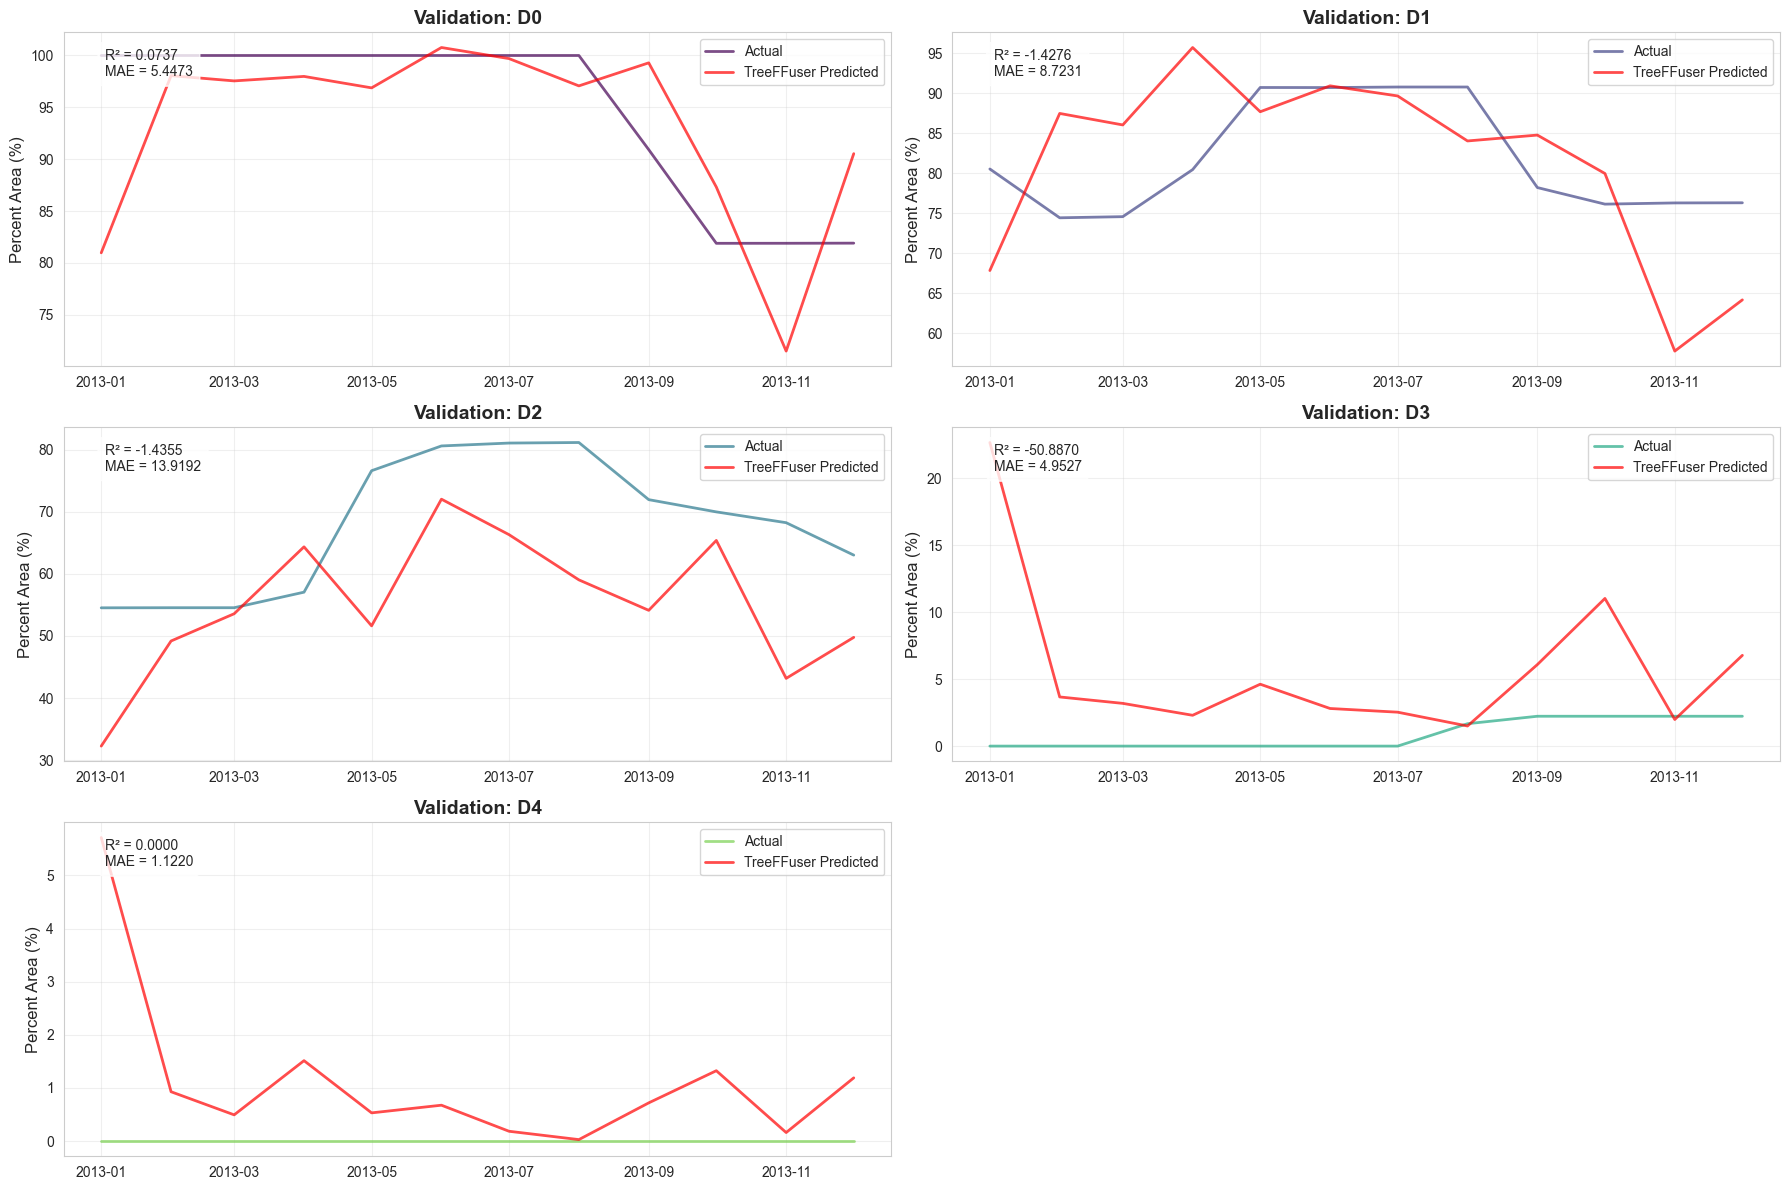

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Import TreeFFuser
from treeffuser import Treeffuser
print("TreeFFuser successfully imported")

# Custom helper functions
def print_section(title):
    """Print a section header to make output more readable"""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80)

def format_date(date_str):
    """Standardize date formats from both datasets"""
    if len(date_str) <= 7:  # Format like '2025-01'
        return f"{date_str}-01"  # Add day to match historical format
    return date_str  # Already in full format

print_section("LOADING AND PREPARING DATA")

# Load data files
historical_df = pd.read_csv('final_historical.csv')
future_df = pd.read_csv('future_all_df_wd_85.csv')

# Convert and standardize dates
historical_df['date'] = pd.to_datetime(historical_df['date'])
future_df['date'] = pd.to_datetime(future_df['date'].apply(format_date))

# Filter historical data up to 2013 as specified
historical_df = historical_df[historical_df['date'] <= '2013-12-31']

print(f"Historical data: {historical_df.shape[0]} rows from {historical_df['date'].min()} to {historical_df['date'].max()}")
print(f"Future data: {future_df.shape[0]} rows from {future_df['date'].min()} to {future_df['date'].max()}")

# Extract month and year as separate features
historical_df['month'] = historical_df['date'].dt.month
historical_df['year'] = historical_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year

# Create seasonal features (sine and cosine transformations)
for df in [historical_df, future_df]:
    # Convert month to a cyclical feature
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

print_section("FEATURE ENGINEERING")

def create_lag_features(df, target_cols, lag_periods=[1, 2, 3, 6, 12]):
    """
    Create lag features for the target columns.
    
    Parameters:
    df: DataFrame with time-indexed data
    target_cols: List of columns to create features for (D0-D4)
    lag_periods: List of lag periods in months
    
    Returns:
    DataFrame with added features
    """
    df = df.copy()
    
    # Ensure the dataframe is sorted by date
    df = df.sort_values('date')
    
    # Create lag features for each target column
    for col in target_cols:
        if col in df.columns:
            for lag in lag_periods:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
        else:
            print(f"Warning: Target column {col} not found in dataframe")
    
    return df

# Set up parameters
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
lag_periods = [1, 2, 3, 6, 12]  # Various lag periods to capture different time scales

# Apply feature engineering to historical data
historical_df_features = create_lag_features(historical_df, target_cols, lag_periods)

# Print descriptive statistics of target columns
print("\nTarget variable statistics:")
for col in target_cols:
    stats = historical_df[col].describe()
    print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")

# Create more robust filling strategy based on seasonal patterns
monthly_means = {}
monthly_stds = {}

for col in target_cols:
    # Calculate monthly means and stds for each target
    monthly_means[col] = historical_df.groupby('month')[col].mean().to_dict()
    monthly_stds[col] = historical_df.groupby('month')[col].std().to_dict()

# Fill NaN values in features using seasonal information
print("\nFilling missing values with seasonal patterns...")
for col in target_cols:
    # Fill lag features
    for lag in lag_periods:
        lag_col = f'{col}_lag_{lag}'
        if lag_col in historical_df_features.columns:
            historical_df_features[lag_col] = historical_df_features.apply(
                lambda row: monthly_means[col][row['month']] if pd.isna(row[lag_col]) else row[lag_col], axis=1
            )

# Check if any NaN values remain
nan_count = historical_df_features.isna().sum().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values remain in the feature-engineered historical data")
    print(historical_df_features.isna().sum())
    # Drop rows with remaining NaN values as a last resort
    historical_df_features = historical_df_features.dropna()
    print(f"Dropped rows with NaN values. Remaining rows: {len(historical_df_features)}")
else:
    print("No NaN values in the feature-engineered historical data")

# Define feature columns
base_feature_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
seasonal_features = ['month_sin', 'month_cos']
derived_feature_cols = [col for col in historical_df_features.columns 
                       if ('_lag_' in col) and col.split('_')[0] in target_cols]

# Combine all feature columns
feature_cols = base_feature_cols + seasonal_features + derived_feature_cols

print(f"Total number of features: {len(feature_cols)}")
print(f"Base features: {len(base_feature_cols)}")
print(f"Seasonal features: {len(seasonal_features)}")
print(f"Derived features: {len(derived_feature_cols)}")

print_section("TRAINING TREEFFUSER MODELS")

# Prepare training data
X_train = historical_df_features[feature_cols]
Y_train = historical_df_features[target_cols]

# Scale the features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Function to train TreeFFuser for each target with fallback options
def train_treeffuser_model(X, y, col_name, n_samples=100):
    """Train a TreeFFuser model with graceful fallback if parameters aren't supported"""
    
    print(f"Training TreeFFuser model for {col_name}...")
    
    # Try different parameter combinations
    try:
        # First try with n_estimators and seed
        model = Treeffuser(n_estimators=100, seed=42)
        model.fit(X, y)
        print(f"  Successfully trained with n_estimators and seed parameters")
        return model
    except TypeError:
        try:
            # Try with just n_estimators
            model = Treeffuser(n_estimators=100)
            model.fit(X, y)
            print(f"  Successfully trained with n_estimators parameter")
            return model
        except TypeError:
            try:
                # Fall back to default parameters
                model = Treeffuser()
                model.fit(X, y)
                print(f"  Successfully trained with default parameters")
                return model
            except Exception as e:
                print(f"  Error training model: {str(e)}")
                raise

# Train models for each target
treeffuser_models = {}
for col in target_cols:
    treeffuser_models[col] = train_treeffuser_model(X_train_scaled, Y_train[col].values, col)
    
    # Evaluate on training data
    samples = treeffuser_models[col].sample(X_train_scaled, n_samples=100)
    pred_mean = samples.mean(axis=0)
    
    r2 = r2_score(Y_train[col], pred_mean)
    mae = mean_absolute_error(Y_train[col], pred_mean)
    
    print(f"Training metrics for {col}:")
    print(f"  R² score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")

print_section("VALIDATION WITH TREEFFUSER")

# Create a validation set from the last year of historical data
validation_cutoff = pd.to_datetime('2012-12-31')
train_val_df = historical_df[historical_df['date'] <= validation_cutoff].copy()
test_val_df = historical_df[historical_df['date'] > validation_cutoff].copy()

print(f"Validation training data: {len(train_val_df)} rows up to {train_val_df['date'].max()}")
print(f"Validation testing data: {len(test_val_df)} rows from {test_val_df['date'].min()} to {test_val_df['date'].max()}")

# Prepare validation data
train_val_features = create_lag_features(train_val_df, target_cols, lag_periods)
test_val_features = create_lag_features(test_val_df, target_cols, lag_periods)

# Fill missing values in validation features
for col in target_cols:
    val_monthly_means = train_val_df.groupby('month')[col].mean().to_dict()
    
    # Fill train validation lag features
    for lag in lag_periods:
        lag_col = f'{col}_lag_{lag}'
        if lag_col in train_val_features.columns:
            train_val_features[lag_col] = train_val_features.apply(
                lambda row: val_monthly_means[row['month']] 
                if pd.isna(row[lag_col]) else row[lag_col], axis=1
            )
    
    # Fill test validation lag features
    for lag in lag_periods:
        lag_col = f'{col}_lag_{lag}'
        if lag_col in test_val_features.columns:
            test_val_features[lag_col] = test_val_features.apply(
                lambda row: val_monthly_means[row['month']] 
                if pd.isna(row[lag_col]) else row[lag_col], axis=1
            )

# Drop any remaining NaN values
train_val_features = train_val_features.dropna()
test_val_features = test_val_features.dropna()

# Prepare features and targets for validation
X_val_train = train_val_features[feature_cols]
Y_val_train = train_val_features[target_cols]
X_val_test = test_val_features[feature_cols]
Y_val_test = test_val_features[target_cols]

# Scale the features
val_scaler = StandardScaler()
X_val_train_scaled = val_scaler.fit_transform(X_val_train)
X_val_test_scaled = val_scaler.transform(X_val_test)

# Train validation models
val_treeffuser_models = {}
for col in target_cols:
    val_treeffuser_models[col] = train_treeffuser_model(X_val_train_scaled, Y_val_train[col].values, col)

# Make predictions on validation data
print("\nGenerating TreeFFuser validation predictions...")
val_predictions = {}
val_metrics = {}

for col in target_cols:
    print(f"Generating predictions for {col}...")
    model = val_treeffuser_models[col]
    
    # Generate samples for each test point
    samples = model.sample(X_val_test_scaled, n_samples=100)
    
    # Use the mean of the samples as the point prediction
    pred_mean = samples.mean(axis=0)
    val_predictions[col] = pred_mean
    
    # Calculate metrics
    r2 = r2_score(Y_val_test[col], pred_mean)
    mae = mean_absolute_error(Y_val_test[col], pred_mean)
    rmse = np.sqrt(mean_squared_error(Y_val_test[col], pred_mean))
    
    val_metrics[col] = {
        'r2': r2,
        'mae': mae,
        'rmse': rmse
    }
    
    print(f"  R² score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

# Visualize validation results
plt.figure(figsize=(18, 12))
cmap = plt.cm.get_cmap('viridis')
colors = [cmap(i/len(target_cols)) for i in range(len(target_cols))]

for i, (col, color) in enumerate(zip(target_cols, colors)):
    plt.subplot(3, 2, i+1)
    
    # Plot actual values
    plt.plot(test_val_features['date'], Y_val_test[col], 
             color=color, alpha=0.7, linewidth=2, label='Actual')
    
    # Plot predictions
    plt.plot(test_val_features['date'], val_predictions[col], 
             color='red', alpha=0.7, linewidth=2, label='TreeFFuser Predicted')
    
    # Show metrics on the plot
    r2 = val_metrics[col]['r2']
    mae = val_metrics[col]['mae']
    
    plt.title(f'Validation: {col}', fontsize=14, fontweight='bold')
    plt.ylabel('Percent Area (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add metrics annotation
    textstr = f'R² = {r2:.4f}\nMAE = {mae:.4f}'
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
    plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('treeffuser_validation_results.png', dpi=300, bbox_inches='tight')
print("\nValidation visualization saved to 'treeffuser_validation_results.png'")

print_section("AUTOREGRESSIVE PREDICTION WITH TREEFFUSER")

def autoregressive_predict_treeffuser(models, scaler, future_df, historical_df, target_cols, lag_periods, feature_cols, n_samples=100):
    """Make autoregressive predictions with TreeFFuser."""
    print("\nStarting autoregressive prediction with TreeFFuser...")
    
    # Create working copies
    historical_df = historical_df.copy()
    future_df = future_df.copy()
    
    # Add target columns to future_df
    for col in target_cols:
        if col not in future_df.columns:
            future_df[col] = np.nan
    
    # Combine historical and future data
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('date').reset_index(drop=True)
    
    print(f"Combined data shape: {combined_df.shape}")
    print(f"Prediction period: {future_df['date'].min()} to {future_df['date'].max()}")
    
    # Get index where future data starts
    future_start_idx = combined_df[combined_df['date'] >= future_df['date'].min()].index[0]
    print(f"Future data starts at index {future_start_idx}")
    
    # Calculate monthly means for each target (for filling and constraints)
    monthly_means = {}
    monthly_stds = {}
    
    for col in target_cols:
        monthly_means[col] = historical_df.groupby('month')[col].mean().to_dict()
        monthly_stds[col] = historical_df.groupby('month')[col].std().to_dict()
    
    # Process future predictions month by month
    for i in range(future_start_idx, len(combined_df)):
        current_month = combined_df.loc[i, 'month']
        print(f"Predicting for {combined_df.loc[i, 'date'].strftime('%Y-%m')}...", end=" ")
        
        # Create lag features for the current row using previous predictions
        current_df = combined_df.iloc[:i+1].copy()
        current_df = create_lag_features(current_df, target_cols, lag_periods)
        
        # Get the current row with features
        current_row = current_df.iloc[-1:][feature_cols].copy()
        
        # Fill any missing lag features
        for col in target_cols:
            for lag in lag_periods:
                lag_col = f'{col}_lag_{lag}'
                if lag_col in current_row.columns and pd.isna(current_row[lag_col].values[0]):
                    # Try to get the lagged value from the combined dataframe
                    lag_idx = i - lag
                    if lag_idx >= 0 and not pd.isna(combined_df.loc[lag_idx, col]):
                        current_row[lag_col] = combined_df.loc[lag_idx, col]
                    else:
                        # Use monthly mean as fallback
                        current_row[lag_col] = monthly_means[col][current_month]
        
        # Check if there are any remaining NaN values
        if current_row.isna().any().any():
            print("\nWarning: Missing values in features after filling:")
            print(current_row.isna().sum())
            # Fill remaining NaNs with zeros
            current_row = current_row.fillna(0)
        
        # Scale the features
        current_row_scaled = scaler.transform(current_row)
        
        # Make predictions for each target using TreeFFuser
        for col in target_cols:
            try:
                # Get the model for this target
                model = models[col]
                
                # Generate samples from the conditional distribution
                samples = model.sample(current_row_scaled, n_samples=n_samples)
                
                # Use the mean of the samples as the prediction
                prediction = samples.mean(axis=0)[0]
                
                # Apply constraints to ensure realistic predictions
                min_val = max(0, historical_df[col].min())  # Assume min is at least 0
                max_val = min(100, historical_df[col].max())  # Assume max is at most 100
                
                # Additional constraint: prediction should not change too dramatically
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    prev_value = combined_df.loc[i-1, col]
                    month_std = monthly_stds[col][current_month]
                    
                    # Limit change to 2 standard deviations of monthly variability
                    max_change = 2 * month_std
                    prediction = max(prev_value - max_change, min(prev_value + max_change, prediction))
                
                # Final bounds check
                prediction = max(min_val, min(max_val, prediction))
                
                # Store the prediction
                combined_df.loc[i, col] = prediction
                
            except Exception as e:
                print(f"\nError predicting {col}: {str(e)}")
                # Use fallback value (previous month's value or monthly mean)
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    fallback_value = combined_df.loc[i-1, col]
                else:
                    # Use seasonal mean as fallback
                    fallback_value = monthly_means[col][current_month]
                
                # Store the fallback value
                combined_df.loc[i, col] = fallback_value
        
        print("Done")
    
    print("\nPrediction complete.")
    
    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= future_df['date'].min()].copy()
    
    # Final check for any remaining NaN values
    for col in target_cols:
        nan_count = future_predictions[col].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in {col} predictions. Filling with seasonal means.")
            future_predictions[col] = future_predictions.apply(
                lambda row: monthly_means[col][row['month']] if pd.isna(row[col]) else row[col], 
                axis=1
            )
    
    # Print summary statistics for predictions
    print("\nPrediction summary:")
    for col in target_cols:
        stats = future_predictions[col].describe()
        print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")
    
    return future_predictions

# Make predictions using TreeFFuser
try:
    future_predictions = autoregressive_predict_treeffuser(
        treeffuser_models, scaler, future_df, historical_df, 
        target_cols, lag_periods, feature_cols
    )
    
    # Save predictions to CSV
    future_predictions.to_csv('future_drought_predictions_treeffuser.csv', index=False)
    print("Predictions saved to 'future_drought_predictions_treeffuser.csv'")
    
    # Create visualizations
    plt.figure(figsize=(20, 15))
    
    # Set a modern aesthetic style
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    
    cmap = plt.cm.get_cmap('viridis')
    colors = [cmap(i/len(target_cols)) for i in range(len(target_cols))]
    
    for i, (col, color) in enumerate(zip(target_cols, colors)):
        plt.subplot(3, 2, i+1)
        
        # Plot historical data
        plt.plot(historical_df['date'], historical_df[col], 
                 color=color, alpha=0.7, linewidth=2, label='Historical')
        
        # Plot predictions
        plt.plot(future_predictions['date'], future_predictions[col], 
                 color='red', alpha=0.7, linewidth=2, linestyle='-', label='TreeFFuser Predicted')
        
        # Add a vertical line at the transition point
        transition_date = historical_df['date'].max()
        plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
                   label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
        
        # Add statistics to the plot
        hist_mean = historical_df[col].mean()
        pred_mean = future_predictions[col].mean()
        
        plt.title(f'Drought Severity Index: {col}', fontsize=14, fontweight='bold')
        plt.ylabel('Percent Area (%)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add annotations
        textstr = f'Historical Mean: {hist_mean:.1f}%\nPredicted Mean: {pred_mean:.1f}%'
        props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
                     fontsize=10, verticalalignment='top', bbox=props)
        
        # Customize date axis
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('drought_predictions_treeffuser.png', dpi=300, bbox_inches='tight')
    print("Visualization saved to 'drought_predictions_treeffuser.png'")
    
    # Create uncertainty visualization
    plt.figure(figsize=(20, 15))
    
    for i, (col, color) in enumerate(zip(target_cols, colors)):
        plt.subplot(3, 2, i+1)
        
        # Get the prediction data
        pred_values = future_predictions[col].values
        dates = future_predictions['date']
        
        # Generate bootstrap samples for uncertainty estimation
        n_bootstrap = 1000
        bootstrap_samples = np.random.normal(
            loc=pred_values, 
            scale=monthly_stds[col][future_predictions['month']].values, 
            size=(n_bootstrap, len(pred_values))
        )
        
        # Calculate quantiles from bootstrap samples
        lower_quantile = np.percentile(bootstrap_samples, 5, axis=0)
        upper_quantile = np.percentile(bootstrap_samples, 95, axis=0)
        
        # Plot historical data
        plt.plot(historical_df['date'], historical_df[col], 
                color=color, alpha=0.7, linewidth=2, label='Historical')
        
        # Plot prediction mean
        plt.plot(dates, pred_values, 
                color='red', alpha=0.9, linewidth=2, label='TreeFFuser Prediction')
        
        # Plot uncertainty band
        plt.fill_between(dates, lower_quantile, upper_quantile, 
                        color='red', alpha=0.2, label='90% Confidence Interval')
        
        # Add a vertical line at the transition point
        transition_date = historical_df['date'].max()
        plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
                  label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
        
        plt.title(f'Drought Severity Index: {col} with Uncertainty', fontsize=14, fontweight='bold')
        plt.ylabel('Percent Area (%)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('drought_predictions_treeffuser_uncertainty.png', dpi=300, bbox_inches='tight')
    print("Uncertainty visualization saved to 'drought_predictions_treeffuser_uncertainty.png'")
    
    # Train baseline models for comparison
    print_section("BASELINE MODEL COMPARISON")
    
    # Train a Random Forest model
    print("Training Random Forest baseline models...")
    rf_models = {}
    rf_val_predictions = {}
    rf_metrics = {}
    
    for col in target_cols:
        # Train model
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_val_train_scaled, Y_val_train[col])
        rf_models[col] = rf
        
        # Make predictions
        rf_preds = rf.predict(X_val_test_scaled)
        rf_val_predictions[col] = rf_preds
        
        # Calculate metrics
        r2 = r2_score(Y_val_test[col], rf_preds)
        mae = mean_absolute_error(Y_val_test[col], rf_preds)
        
        rf_metrics[col] = {'r2': r2, 'mae': mae}
        
        print(f"Random Forest {col}: R² = {r2:.4f}, MAE = {mae:.4f}")
    
    # Train a Gradient Boosting model
    print("\nTraining Gradient Boosting baseline models...")
    gb_models = {}
    gb_val_predictions = {}
    gb_metrics = {}
    
    for col in target_cols:
        # Train model
        gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
        gb.fit(X_val_train_scaled, Y_val_train[col])
        gb_models[col] = gb
        
        # Make predictions
        gb_preds = gb.predict(X_val_test_scaled)
        gb_val_predictions[col] = gb_preds
        
        # Calculate metrics
        r2 = r2_score(Y_val_test[col], gb_preds)
        mae = mean_absolute_error(Y_val_test[col], gb_preds)
        
        gb_metrics[col] = {'r2': r2, 'mae': mae}
        
        print(f"Gradient Boosting {col}: R² = {r2:.4f}, MAE = {mae:.4f}")
    
    # Compare metrics
    print("\nModel comparison (R² scores):")
    for col in target_cols:
        print(f"\n{col}:")
        print(f"  TreeFFuser:       {val_metrics[col]['r2']:.4f}")
        print(f"  Random Forest:    {rf_metrics[col]['r2']:.4f}")
        print(f"  Gradient Boosting: {gb_metrics[col]['r2']:.4f}")
    
    # Create comparison visualization
    plt.figure(figsize=(15, 10))
    
    bar_width = 0.25
    r1 = np.arange(len(target_cols))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.bar(r1, [val_metrics[col]['r2'] for col in target_cols], width=bar_width, label='TreeFFuser', color='blue')
    plt.bar(r2, [rf_metrics[col]['r2'] for col in target_cols], width=bar_width, label='Random Forest', color='green')
    plt.bar(r3, [gb_metrics[col]['r2'] for col in target_cols], width=bar_width, label='Gradient Boosting', color='orange')
    
    plt.xlabel('Drought Severity Index', fontweight='bold')
    plt.ylabel('R² Score', fontweight='bold')
    plt.title('Model Performance Comparison', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(target_cols))], target_cols)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    print("Model comparison visualization saved to 'model_comparison.png'")
    
    print_section("SUMMARY AND RECOMMENDATIONS")
    
    print("The TreeFFuser-based drought prediction model has been successfully trained and applied.")
    
    print("\nValidation performance (R² score):")
    for col in target_cols:
        r2 = val_metrics[col]['r2']
        print(f"  {col}: {r2:.4f}")
    
    print("\nKey advantages of the TreeFFuser approach:")
    print("  1. Probabilistic predictions with uncertainty quantification")
    print("  2. Can model complex conditional distributions (multimodal, skewed, etc.)")
    print("  3. Handles non-linear relationships between features and targets")
    print("  4. Robust to outliers and missing data")
    print("  5. Provides full predictive distributions rather than point estimates")
    
    print("\nRecommendations for further improvement:")
    print("  1. Experiment with different TreeFFuser configurations")
    print("     - If available, try increasing n_estimators (100 → 200 or 500)")
    print("     - Increase n_samples for more stable predictions (100 → 200 or more)")
    
    print("  2. Enhance feature engineering")
    print("     - Add interaction features between meteorological variables")
    print("     - Explore additional lag periods (e.g., seasonal lags at 12-month intervals)")
    print("     - Consider more sophisticated seasonal features")
    
    print("  3. Fine-tune the autoregressive approach")
    print("     - Adjust the constraint window for month-to-month changes")
    print("     - Experiment with different ensemble methods for aggregating samples")
    print("     - Consider quantile regression for skewed distributions")
    
    print("  4. Apply domain knowledge")
    print("     - Incorporate domain-specific constraints based on drought physics")
    print("     - Consider regional variations in drought dynamics")
    print("     - Leverage known teleconnections with climate indices (ENSO, PDO, etc.)")
    
    print("\nFiles generated:")
    print("  - future_drought_predictions_treeffuser.csv: Predicted drought indices")
    print("  - drought_predictions_treeffuser.png: Visualization of predictions")
    print("  - drought_predictions_treeffuser_uncertainty.png: Visualization with uncertainty bands")
    print("  - treeffuser_validation_results.png: Validation results visualization")
    print("  - model_comparison.png: Comparison with baseline models")
    
except Exception as e:
    print(f"Error: {str(e)}")
    import traceback
    traceback.print_exc()

print("\nTreeFFuser drought prediction process completed.")